In [1]:
import os
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Load the data into a DataFrame
folder_path = "/Users/karolinabargiel/Downloads/Small LCL Data"
all_files = os.listdir(folder_path)
first_files_paths = [os.path.join(folder_path, file_name) for file_name in all_files[:10]]

dfs = []
for file_path in first_files_paths:
    df = pd.read_csv(file_path)
    dfs.append(df)

combined_df = pd.concat(dfs)

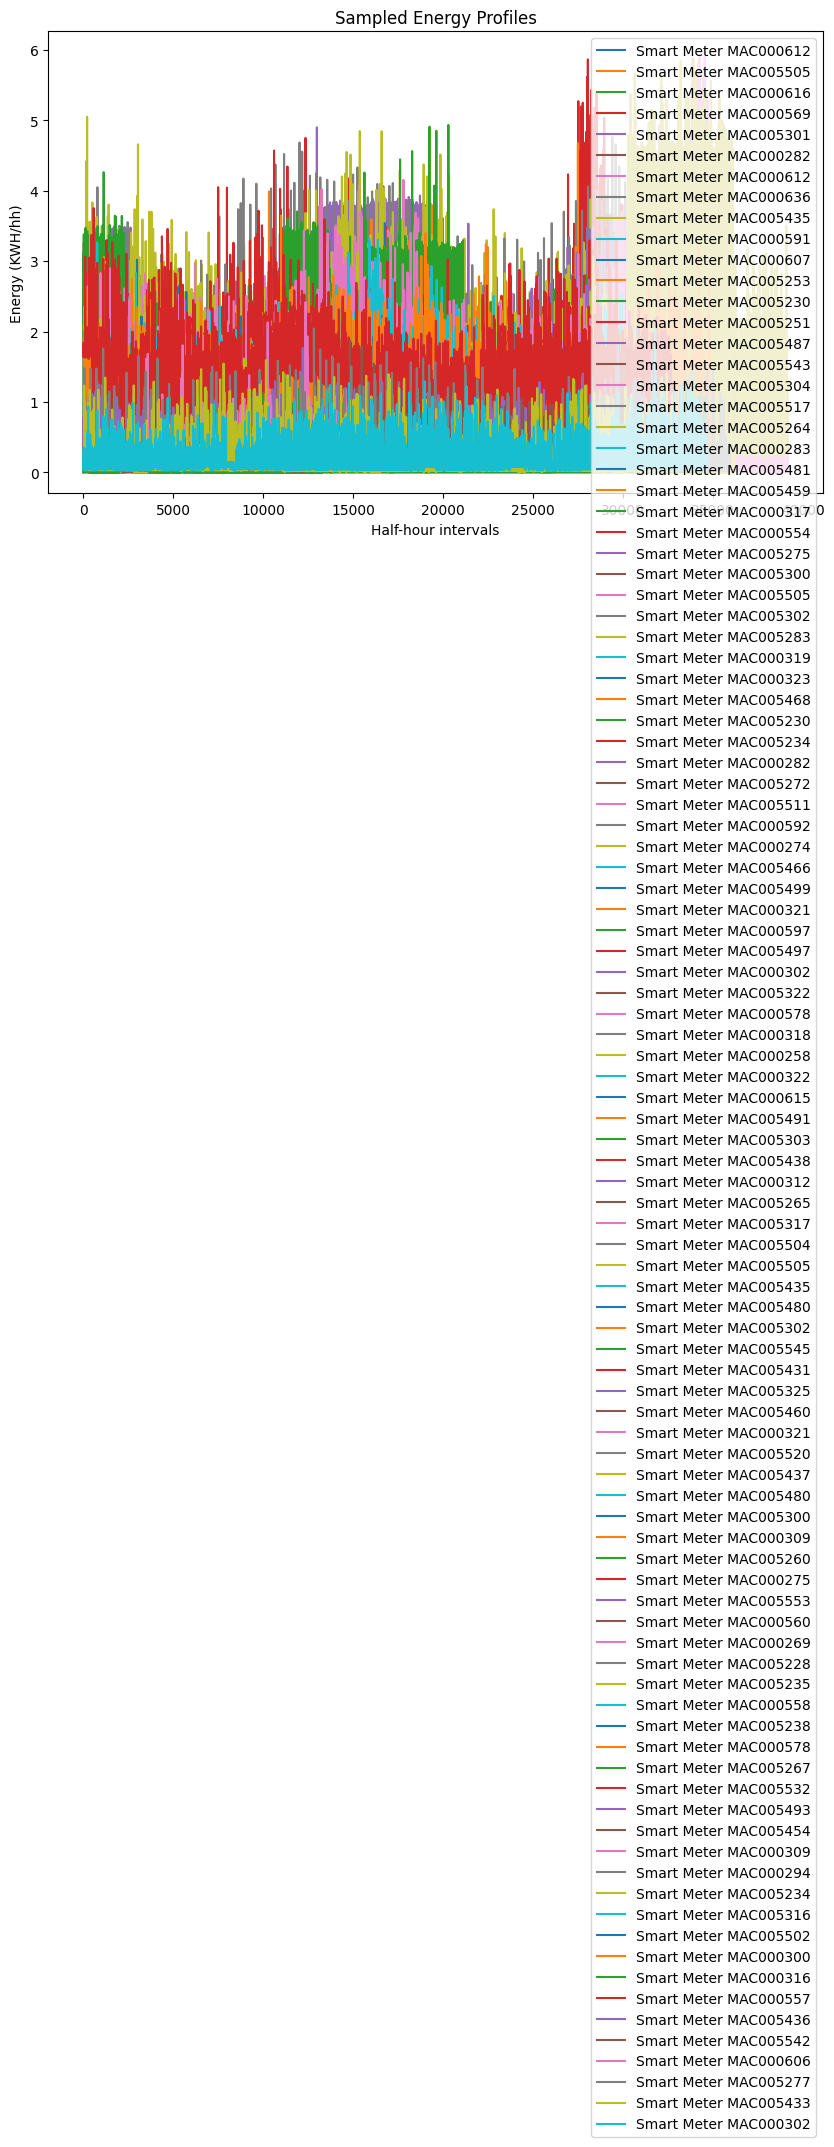

In [3]:
# Group data by 'LCLid' to gather yearly energy profiles
grouped_data = combined_df.groupby('LCLid')

# Aggregate 'KWH/hh (per half hour)' column into lists
yearly_profiles = grouped_data['KWH/hh (per half hour) '].apply(list)

# Convert each list of energy readings into a single string representing yearly profile
yearly_profiles = yearly_profiles.apply(lambda x: ','.join(map(str, x)))

# Convert the profiles back to DataFrame
yearly_profiles_df = pd.DataFrame(yearly_profiles)
yearly_profiles_df['LCLid'] = yearly_profiles_df.index

# Sample a subset of energy profiles for plotting
sample_size = min(100, len(yearly_profiles_df))  # Ensure sample size is not greater than the number of rows
sampled_profiles = yearly_profiles_df.sample(n=sample_size, replace=True, random_state=42)

# Split the comma-separated values into individual columns
sampled_profiles['Energy_Profile'] = sampled_profiles['KWH/hh (per half hour) '].str.split(',')
sampled_profiles = sampled_profiles.drop(columns=['KWH/hh (per half hour) '])

# Convert energy profiles to numeric values
# Replace 'Null' with NaN in 'Energy_Profile' column
sampled_profiles['Energy_Profile'] = sampled_profiles['Energy_Profile'].apply(lambda x: [float(val) if val != 'Null' else np.nan for val in x])

# Plot the sampled energy profiles
plt.figure(figsize=(10, 6))
for i, profile in enumerate(sampled_profiles['Energy_Profile']):
    plt.plot(profile, label=f'Smart Meter {sampled_profiles.index[i]}')

plt.xlabel('Half-hour intervals')
plt.ylabel('Energy (KWH/hh)')
plt.title('Sampled Energy Profiles')
plt.legend()
plt.show()


Yearly clustering

In [4]:
dfs = []
for file_path in first_files_paths:
    df = pd.read_csv(file_path, parse_dates=['DateTime'])
    # Convert energy consumption column to numeric, handling non-numeric and missing data
    df['KWH/hh (per half hour) '] = pd.to_numeric(df['KWH/hh (per half hour) '].str.strip(), errors='coerce')
    dfs.append(df)

combined_df = pd.concat(dfs)


# Add a column for week of the year
combined_df['Week'] = combined_df['DateTime'].dt.isocalendar().week

#  Group data by 'LCLid' and 'Week' to gather weekly energy profiles
grouped_data = combined_df.groupby(['LCLid', 'Week'])

# Aggregate 'KWH/hh (per half hour)' into weekly averages
weekly_profiles = grouped_data['KWH/hh (per half hour) '].mean().unstack()

# Print to check if DataFrame is empty after aggregation
print("Weekly Profiles Shape:", weekly_profiles.shape)
print("Weekly Profiles Sample:\n", weekly_profiles.head())




Weekly Profiles Shape: (303, 52)
Weekly Profiles Sample:
 Week             1         2         3         4         5         6   \
LCLid                                                                   
MAC000256  0.663821  0.655030  0.543083  0.414423  0.492386  0.526738   
MAC000258  0.185313  0.185571  0.190563  0.188011  0.192225  0.189916   
MAC000260  0.248222  0.232572  0.198370  0.208373  0.271207  0.335561   
MAC000262  0.370279  0.419004  0.416629  0.414123  0.437174  0.427949   
MAC000263  0.105682  0.107376  0.110316  0.109060  0.106414  0.111446   

Week             7         8         9         10  ...        43        44  \
LCLid                                              ...                       
MAC000256  0.353634  0.338217  0.268933       NaN  ...  0.332243  0.512595   
MAC000258  0.190689  0.183496  0.179372  0.176799  ...  0.164955  0.159420   
MAC000260  0.297557  0.290297  0.298562  0.298574  ...  0.042554  0.166923   
MAC000262  0.421127  0.392114  0.347408 

In [5]:
# Prepare data for clustering
# Transpose and replace NaN with a value indicating no data for that week
weekly_profiles_clean = weekly_profiles.transpose().fillna(value=0)  # Replace dropna() with fillna(0)

# Print to verify the shape and sample data
print("Weekly Profiles Clean Shape:", weekly_profiles_clean.shape)
print("Weekly Profiles Clean Sample:\n", weekly_profiles_clean.head())

# Convert DataFrame to proper format for clustering
data_for_clustering = weekly_profiles_clean.values.T  # Transpose to get correct shape

# Clustering
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(data_for_clustering)



Weekly Profiles Clean Shape: (52, 303)
Weekly Profiles Clean Sample:
 LCLid  MAC000256  MAC000258  MAC000260  MAC000262  MAC000263  MAC000264  \
Week                                                                      
1       0.663821   0.185313   0.248222   0.370279   0.105682   0.235686   
2       0.655030   0.185571   0.232572   0.419004   0.107376   0.219277   
3       0.543083   0.190563   0.198370   0.416629   0.110316   0.185685   
4       0.414423   0.188011   0.208373   0.414123   0.109060   0.173128   
5       0.492386   0.192225   0.271207   0.437174   0.106414   0.189414   

LCLid  MAC000267  MAC000268  MAC000269  MAC000270  ...  MAC005543  MAC005544  \
Week                                               ...                         
1       0.281727   0.103418   0.061536   0.453617  ...   0.421879   0.097031   
2       0.254443   0.098995   0.060416   0.420257  ...   0.458912   0.100707   
3       0.263201   0.093203   0.061630   0.417896  ...   0.488348   0.087227   
4   

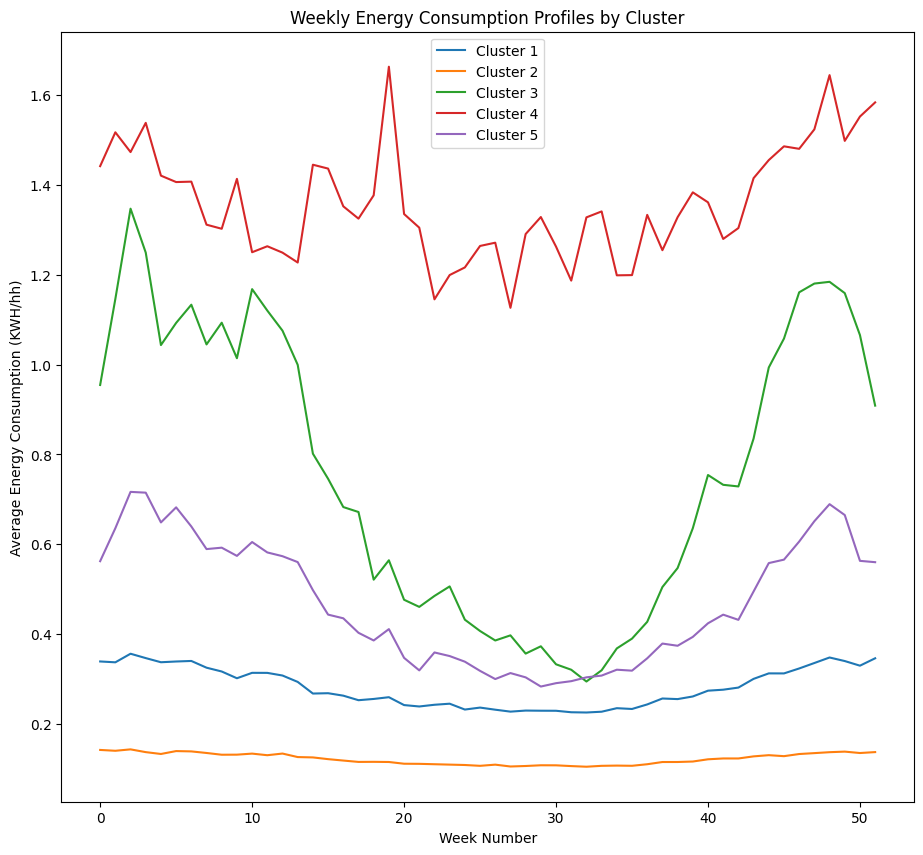

In [6]:
# Plot the results
plt.figure(figsize=(11, 10))
for i in range(5):  # Plot each cluster's centroid
    plt.plot(kmeans.cluster_centers_[i], label=f'Cluster {i+1}')

plt.xlabel('Week Number')
plt.ylabel('Average Energy Consumption (KWH/hh)')
plt.title('Weekly Energy Consumption Profiles by Cluster')
plt.legend()
plt.show()

Daily clustering

In [7]:
# Extract day of week and half-hour
combined_df['DayOfWeek'] = combined_df['DateTime'].dt.dayofweek
combined_df['HalfHour'] = combined_df['DateTime'].dt.hour * 2 + combined_df['DateTime'].dt.minute // 30

# Group data by 'LCLid', 'DayOfWeek' and 'HalfHour'
grouped_data = combined_df.groupby(['LCLid', 'DayOfWeek', 'HalfHour'])

# Aggregate 'KWH/hh (per half hour)' into average per each half-hour slot
average_profiles = grouped_data['KWH/hh (per half hour) '].mean().unstack([1, 2])

# Fill NaNs (indicating no data for specific times) with 0 or a reasonable substitute
average_profiles = average_profiles.fillna(0)

# Convert DataFrame to proper format for clustering
data_for_clustering = average_profiles.values

# Clustering
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(data_for_clustering)




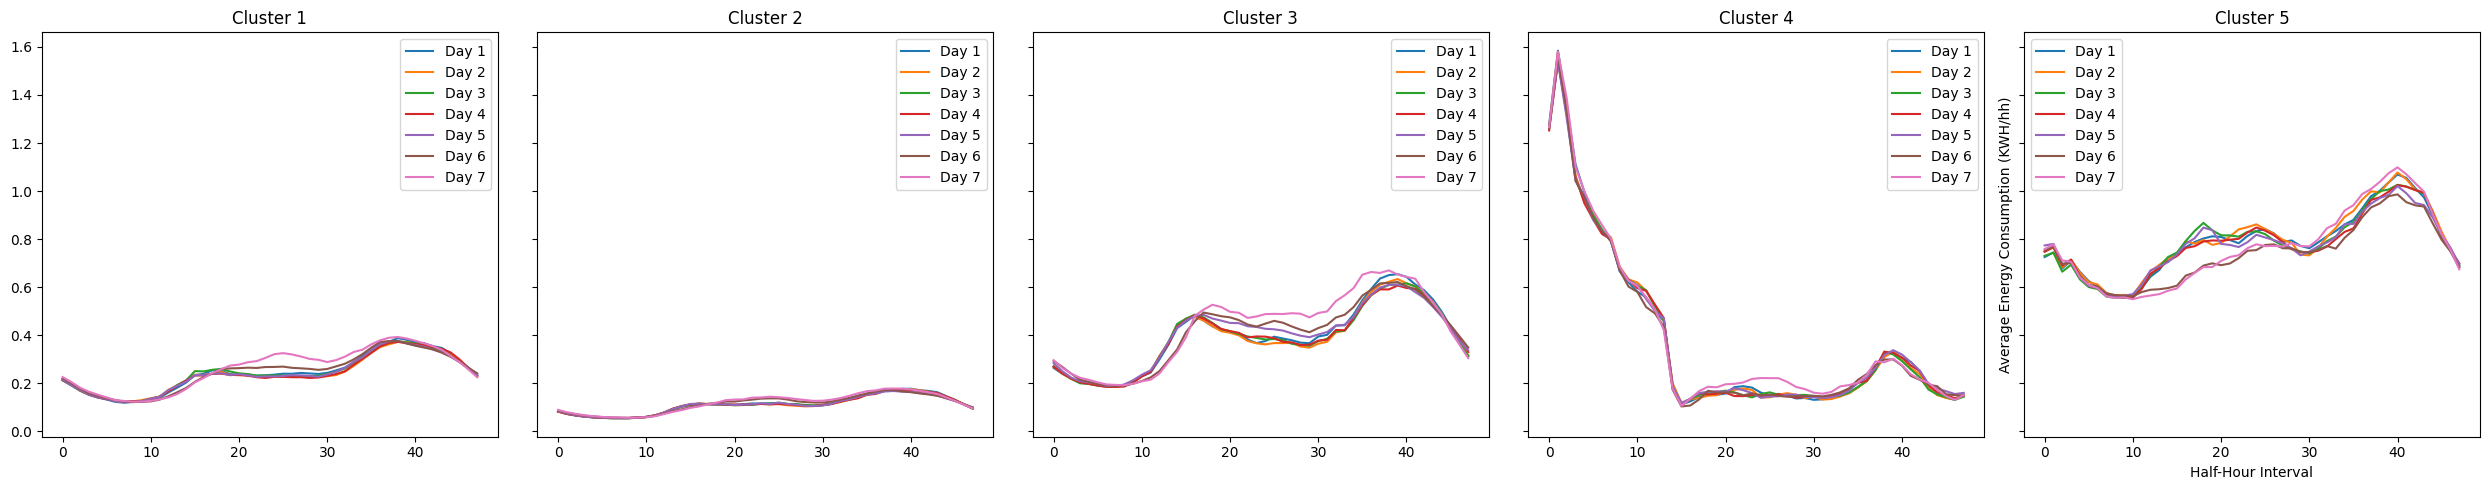

In [8]:
# Plot the results
fig, axes = plt.subplots(1, 5, figsize=(25, 5), sharey=True)
for i in range(5):
    # Reshape cluster center to 7 days x 48 half-hours format
    cluster_center = kmeans.cluster_centers_[i].reshape(7, 48)
    for day in range(7):
        axes[i].plot(cluster_center[day], label=f'Day {day + 1}')
    axes[i].set_title(f'Cluster {i + 1}')
    axes[i].legend()

plt.xlabel('Half-Hour Interval')
plt.ylabel('Average Energy Consumption (KWH/hh)')
plt.tight_layout()
plt.show()

Weekly clustering

In [9]:
# Group data by 'LCLid', 'DayOfWeek' and 'HalfHour'
grouped_data = combined_df.groupby(['LCLid', 'DayOfWeek', 'HalfHour'])

# Aggregate 'KWH/hh (per half hour)' into average per each half-hour slot
average_profiles = grouped_data['KWH/hh (per half hour) '].mean().unstack([1, 2])

# Ensure all time slots are represented even if no data is available (fill with zeros)
average_profiles = average_profiles.fillna(0)

# Flatten the DataFrame so each row is one continuous week profile per user
data_for_clustering = average_profiles.values

# Clustering
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(data_for_clustering)




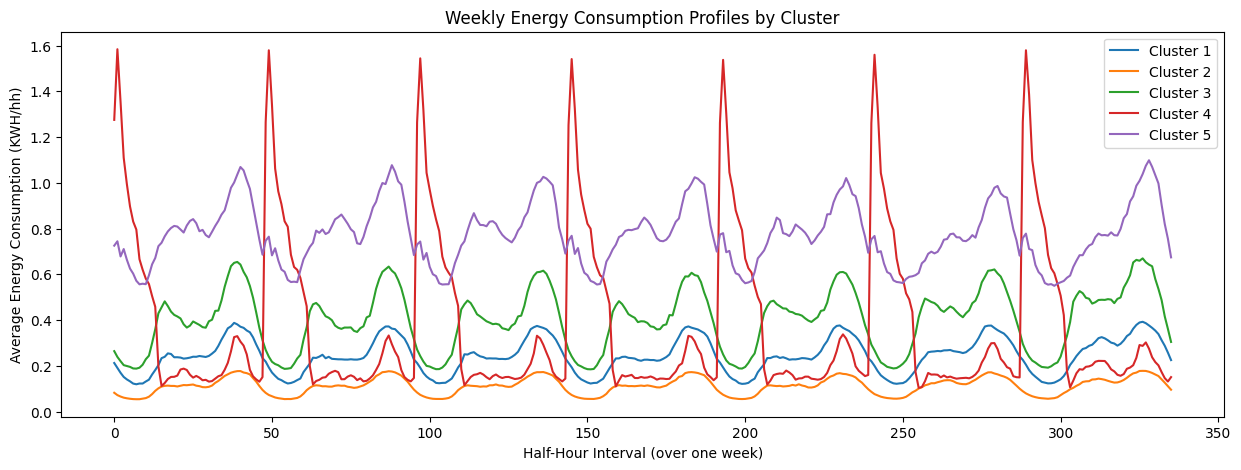

In [10]:
# Plot the results
plt.figure(figsize=(15, 5))
for i in range(5):
    # Average the cluster centers across all members of each cluster
    cluster_center = np.mean(data_for_clustering[clusters == i], axis=0)
    plt.plot(cluster_center, label=f'Cluster {i+1}')

plt.xlabel('Half-Hour Interval (over one week)')
plt.ylabel('Average Energy Consumption (KWH/hh)')
plt.title('Weekly Energy Consumption Profiles by Cluster')
plt.legend()
plt.show()

CO2 intensity data analysis

In [11]:
# Load the CO2 intensity data and filter for 2023
co2_path = '/Users/karolinabargiel/PeerCarbon/github/processed_carbon_intensity_2.csv'
co2_data = pd.read_csv(co2_path, parse_dates=['Timestamp'])

# Filter for the year 2023 only
co2_data = co2_data[co2_data['Timestamp'].dt.year == 2023]

# Sort and create a continuous half-hour coverage index
co2_data['HalfHourIndex'] = co2_data['Timestamp'].dt.dayofyear * 48 + co2_data['Timestamp'].dt.hour * 2 + co2_data['Timestamp'].dt.minute // 30
co2_data = co2_data.sort_values('Timestamp').reset_index(drop=True)

# Generate the expected index range for the entire year
start_index = co2_data['HalfHourIndex'].min()
end_index = start_index + 365 * 48 - 1  # 365 days, 48 half-hours each
expected_index = np.arange(start_index, end_index + 1)

# Determine missing indices
actual_index = co2_data['HalfHourIndex'].values
missing_indices = np.setdiff1d(expected_index, actual_index)

# Identify missing dates
missing_dates = pd.to_datetime(missing_indices // 48, unit='D', origin=pd.Timestamp('2023-01-01')) + \
                pd.to_timedelta((missing_indices % 48) * 30, unit='m')
print("Missing dates and times:", missing_dates)

# Fill missing data by repeating the last available CO2 value
filled_co2_data = pd.DataFrame(expected_index, columns=['HalfHourIndex'])
filled_co2_data = filled_co2_data.merge(co2_data, on='HalfHourIndex', how='left')
filled_co2_data['Value'].fillna(method='ffill', inplace=True)  # Fill forward with the last available data

# Verify the result
if len(filled_co2_data) == len(expected_index):
    print("Data is now complete with filled values for missing intervals.")
else:
    print("There was an error in filling the data.")

# Store the filled values as the annual CO2 values
co2_annual_values = filled_co2_data['Value'].values
print(len(co2_annual_values))


Missing dates and times: DatetimeIndex(['2023-10-21 22:00:00', '2023-10-21 22:30:00',
               '2023-10-21 23:00:00', '2023-10-21 23:30:00',
               '2023-10-22 00:00:00', '2023-10-22 00:30:00',
               '2023-10-22 01:00:00', '2023-10-22 01:30:00',
               '2023-10-22 02:00:00', '2023-10-22 02:30:00',
               '2023-10-22 03:00:00', '2023-10-22 03:30:00',
               '2023-10-22 04:00:00', '2023-10-22 04:30:00',
               '2023-10-22 05:00:00', '2023-10-22 05:30:00',
               '2023-10-22 06:00:00', '2023-10-22 06:30:00',
               '2023-10-22 07:00:00', '2023-10-22 07:30:00',
               '2023-10-22 08:00:00', '2023-10-22 08:30:00',
               '2023-10-22 09:00:00', '2023-10-22 09:30:00',
               '2023-10-22 10:00:00', '2023-10-22 10:30:00',
               '2023-10-22 11:00:00', '2023-10-22 11:30:00',
               '2023-10-22 12:00:00', '2023-10-22 12:30:00',
               '2023-10-22 13:00:00', '2023-10-22 13:30:00',

/var/folders/6g/f3y_cgbn1jg0cwr_s63ptgy40000gn/T/ipykernel_97396/3961392198.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  filled_co2_data['Value'].fillna(method='ffill', inplace=True)  # Fill forward with the last available data
/var/folders/6g/f3y_cgbn1jg0cwr_s63ptgy40000gn/T/ipykernel_97396/3961392198.py:29: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filled_co2_data['Value'].fillna(method='ffill', inplace=True)  # Fill forward 

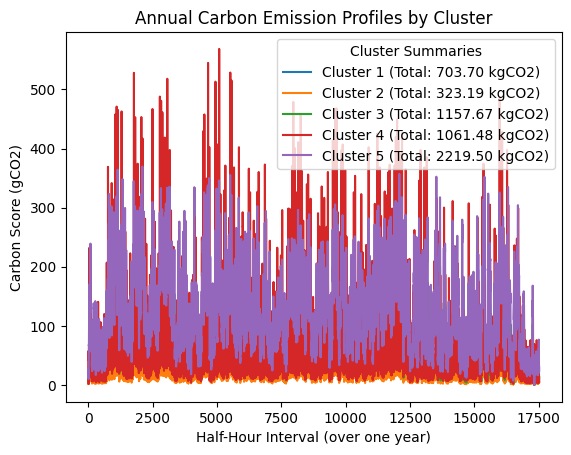

Total kgCO2 for Cluster 1: 703.70 kg
Total kgCO2 for Cluster 2: 323.19 kg
Total kgCO2 for Cluster 3: 1157.67 kg
Total kgCO2 for Cluster 4: 1061.48 kg
Total kgCO2 for Cluster 5: 2219.50 kg


In [12]:
# Assuming 'data_for_clustering' and 'clusters' from previous analysis
annual_carbon_scores = []
kgCO2_annual_totals = []

# Correct the number of weeks per year to match exactly 365 days
weeks_per_year = 365 // 7  # full weeks per year
additional_days = 365 % 7  # days to be added to cover a full year

for i in range(5):  # Assuming 5 clusters
    # Get the mean weekly profile for this cluster
    cluster_data = data_for_clustering[clusters == i]
    weekly_mean_profile = cluster_data.mean(axis=0)
    
    # Repeat the weekly pattern to cover all full weeks in the year
    annual_energy_profile = np.tile(weekly_mean_profile, weeks_per_year)
    
    # Append the additional days to cover the full year
    if additional_days > 0:
        additional_profile = weekly_mean_profile[:additional_days * 48]  # assuming 48 intervals per day
        annual_energy_profile = np.concatenate((annual_energy_profile, additional_profile))
    
    # Ensure the length matches the CO2 data exactly
    if len(annual_energy_profile) != len(co2_annual_values):
        print("Adjusting length mismatch")
        annual_energy_profile = np.concatenate((annual_energy_profile, annual_energy_profile[:len(co2_annual_values) - len(annual_energy_profile)]))

    # Calculate the carbon score for the year
    annual_carbon_score = annual_energy_profile * co2_annual_values
    annual_carbon_scores.append(annual_carbon_score)
    
    # Calculate the total emissions in kg
    total_kgCO2 = np.sum(annual_carbon_score) / 1000  # Convert grams to kilograms
    kgCO2_annual_totals.append(total_kgCO2)

    # Plotting each cluster's annual carbon score
    plt.plot(annual_carbon_score, label=f'Cluster {i+1} (Total: {total_kgCO2:.2f} kgCO2)')

plt.xlabel('Half-Hour Interval (over one year)')
plt.ylabel('Carbon Score (gCO2)')
plt.title('Annual Carbon Emission Profiles by Cluster')
plt.legend(title="Cluster Summaries", loc='upper right')
plt.show()

# Print the total kgCO2 for each cluster
for i, total in enumerate(kgCO2_annual_totals):
    print(f"Total kgCO2 for Cluster {i+1}: {total:.2f} kg")


Seperate grpahs for clusters

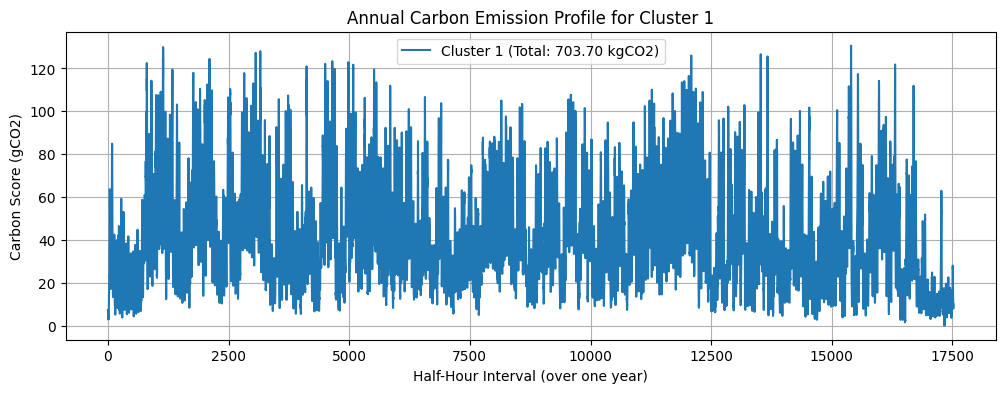

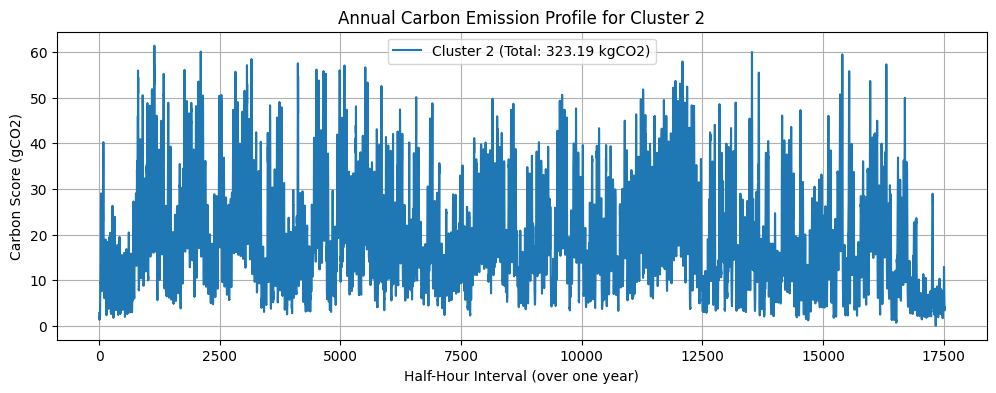

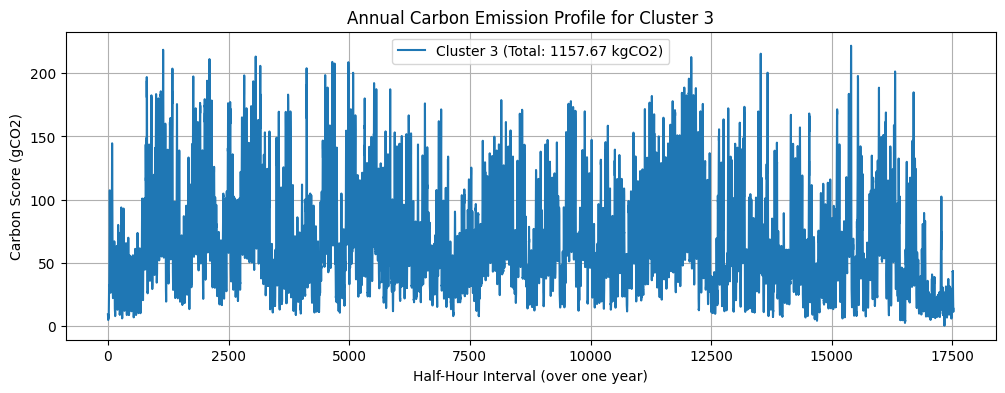

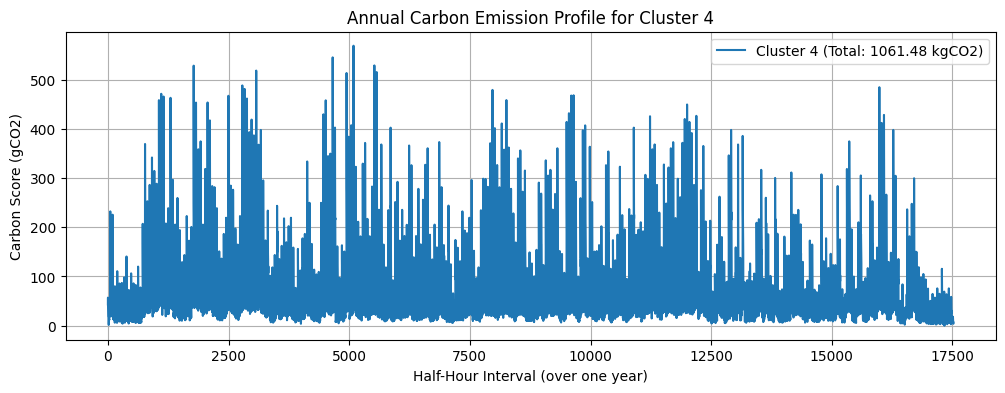

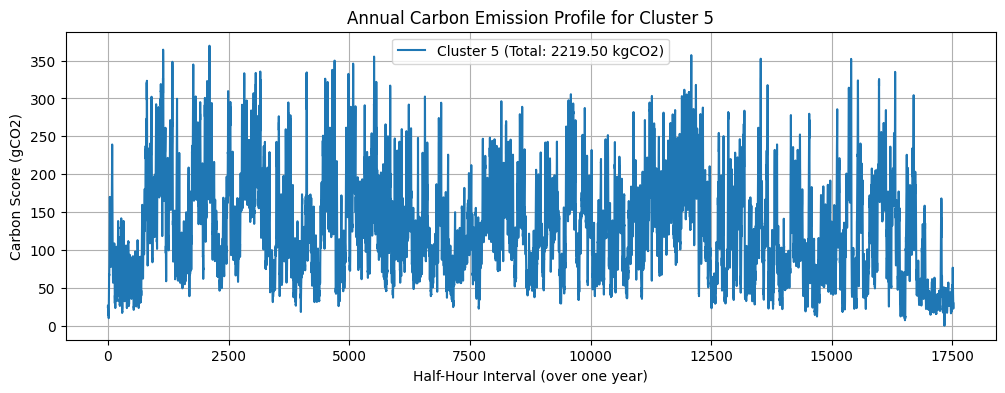

Total kgCO2 for Cluster 1: 703.70 kg
Total kgCO2 for Cluster 2: 323.19 kg
Total kgCO2 for Cluster 3: 1157.67 kg
Total kgCO2 for Cluster 4: 1061.48 kg
Total kgCO2 for Cluster 5: 2219.50 kg


In [13]:
for i, carbon_score in enumerate(annual_carbon_scores):
    plt.figure(figsize=(12, 4))  # Define the figure size
    plt.plot(carbon_score, label=f'Cluster {i+1} (Total: {kgCO2_annual_totals[i]:.2f} kgCO2)')
    plt.xlabel('Half-Hour Interval (over one year)')
    plt.ylabel('Carbon Score (gCO2)')
    plt.title(f'Annual Carbon Emission Profile for Cluster {i+1}')
    plt.legend()
    plt.grid(True)  # Adding a grid for better readability
    plt.show()

# Optionally, print the total kgCO2 for each cluster after plotting
for i, total in enumerate(kgCO2_annual_totals):
    print(f"Total kgCO2 for Cluster {i+1}: {total:.2f} kg")

Flexing the load - 30% of total daily energy to redistribute

In [14]:

new_annual_carbon_scores = []
new_kgCO2_annual_totals = []

# Correct number of weeks to exactly cover 365 days
weeks_per_year = 365 // 7  # Full weeks per year
additional_days = 365 % 7  # Additional days needed to complete the year

for i in range(5):  # Assuming 5 clusters
    cluster_data = data_for_clustering[clusters == i]
    weekly_mean_profile = cluster_data.mean(axis=0)
    
    # Repeat the weekly pattern to cover the full weeks in the year
    annual_energy_profile = np.tile(weekly_mean_profile, weeks_per_year)
    
    # Add the remaining days' energy profile
    if additional_days > 0:
        additional_profile = weekly_mean_profile[:additional_days * 48]  # Assuming 48 intervals per day
        annual_energy_profile = np.concatenate((annual_energy_profile, additional_profile))
    
    # Match the length of the CO2 data, if necessary
    if len(annual_energy_profile) > len(co2_annual_values):
        annual_energy_profile = annual_energy_profile[:len(co2_annual_values)]

    # Reshape annual energy profile to daily for easier manipulation
    daily_profiles = annual_energy_profile.reshape(-1, 48)
    adjusted_daily_profiles = np.copy(daily_profiles)

    for day in range(daily_profiles.shape[0]):
        daily_energy = daily_profiles[day]
        daily_co2_intensity = co2_annual_values[day * 48:(day + 1) * 48]

        # Calculate 30% of total daily energy to redistribute
        energy_to_redistribute = np.sum(daily_energy) * 0.30

        # Reduce each slot by an amount that sums to 30% of total energy
        adjusted_daily_profiles[day] *= (1 - 0.30)

        # Identify indices of the six lowest CO2 half-hour slots
        lowest_indices = np.argsort(daily_co2_intensity)[:6]

        # Calculate the amount to add to each of the lowest carbon slots
        added_energy_per_slot = energy_to_redistribute / 6

        # Apply the redistribution
        for index in lowest_indices:
            adjusted_daily_profiles[day, index] += added_energy_per_slot

    # Flatten the adjusted profiles back to annual
    adjusted_annual_profile = adjusted_daily_profiles.flatten()

    # Calculate new carbon scores
    new_annual_carbon_score = adjusted_annual_profile * co2_annual_values
    new_annual_carbon_scores.append(new_annual_carbon_score)

    # Calculate new total emissions in kg
    new_total_kgCO2 = np.sum(new_annual_carbon_score) / 1000
    new_kgCO2_annual_totals.append(new_total_kgCO2)

    # Plotting the new annual carbon score for this cluster
    #plt.figure(figsize=(10, 4))
    #plt.plot(new_annual_carbon_score, label=f'Adjusted Cluster {i+1}')
    #plt.title(f'Adjusted Carbon Score for Cluster {i+1}')
    #plt.xlabel('Half-Hour Interval (over one year)')
    #plt.ylabel('Carbon Score (gCO2)')
    #plt.legend()
    #plt.grid(True)
    #plt.show()

    print(f"Original Total kgCO2 for Cluster {i+1}: {kgCO2_annual_totals[i]:.2f} kg")
    print(f"Adjusted Total kgCO2 for Cluster {i+1}: {new_total_kgCO2:.2f} kg")


Original Total kgCO2 for Cluster 1: 703.70 kg
Adjusted Total kgCO2 for Cluster 1: 633.73 kg
Original Total kgCO2 for Cluster 2: 323.19 kg
Adjusted Total kgCO2 for Cluster 2: 290.99 kg
Original Total kgCO2 for Cluster 3: 1157.67 kg
Adjusted Total kgCO2 for Cluster 3: 1042.14 kg
Original Total kgCO2 for Cluster 4: 1061.48 kg
Adjusted Total kgCO2 for Cluster 4: 964.18 kg
Original Total kgCO2 for Cluster 5: 2219.50 kg
Adjusted Total kgCO2 for Cluster 5: 2002.12 kg


Flexing the load -  six most and least carbon-intensive half-hours

In [15]:
new_annual_carbon_scores = []
new_kgCO2_annual_totals = []


for i in range(5):  # Assuming 5 clusters
    cluster_data = data_for_clustering[clusters == i]
    weekly_mean_profile = cluster_data.mean(axis=0)
    
    # Repeat the weekly pattern to cover the full weeks in the year
    annual_energy_profile = np.tile(weekly_mean_profile, weeks_per_year)
    
    # Add the remaining days' energy profile
    if additional_days > 0:
        additional_profile = weekly_mean_profile[:additional_days * 48]  # Assuming 48 intervals per day
        annual_energy_profile = np.concatenate((annual_energy_profile, additional_profile))
    
    # Match the length of the CO2 data, if necessary
    if len(annual_energy_profile) > len(co2_annual_values):
        annual_energy_profile = annual_energy_profile[:len(co2_annual_values)]

    # Reshape annual energy profile to daily for easier manipulation
    daily_profiles = annual_energy_profile.reshape(-1, 48)
    adjusted_daily_profiles = np.copy(daily_profiles)

    for day in range(daily_profiles.shape[0]):
        daily_energy = daily_profiles[day]
        daily_co2_intensity = co2_annual_values[day * 48:(day + 1) * 48]

        # Identify indices of the six most and least carbon-intensive half-hours
        most_intensive_indices = np.argsort(daily_co2_intensity)[-6:]
        least_intensive_indices = np.argsort(daily_co2_intensity)[:6]

        # Calculate the total energy to be shifted from the most intensive half-hours
        total_energy_to_shift = np.sum(daily_energy[most_intensive_indices])

        # Remove all energy from the most intensive and distribute it to the least intensive
        adjusted_daily_profiles[day, most_intensive_indices] = 0
        added_energy_per_slot = total_energy_to_shift / 6
        adjusted_daily_profiles[day, least_intensive_indices] += added_energy_per_slot

    # Flatten the adjusted profiles back to annual
    adjusted_annual_profile = adjusted_daily_profiles.flatten()

    # Calculate new carbon scores
    new_annual_carbon_score = adjusted_annual_profile * co2_annual_values
    new_annual_carbon_scores.append(new_annual_carbon_score)

    # Calculate new total emissions in kg
    new_total_kgCO2 = np.sum(new_annual_carbon_score) / 1000
    new_kgCO2_annual_totals.append(new_total_kgCO2)

    # Plotting the new annual carbon score for this cluster
    #plt.figure(figsize=(10, 4))
    #plt.plot(new_annual_carbon_score, label=f'Adjusted Cluster {i+1}')
    #plt.title(f'Adjusted Carbon Score for Cluster {i+1}')
    #plt.xlabel('Half-Hour Interval (over one year)')
    #plt.ylabel('Carbon Score (gCO2)')
    #plt.legend()
    #plt.grid(True)
    #plt.show()

    print(f"Original Total kgCO2 for Cluster {i+1}: {kgCO2_annual_totals[i]:.2f} kg")
    print(f"Adjusted Total kgCO2 for Cluster {i+1}: {new_total_kgCO2:.2f} kg")


Original Total kgCO2 for Cluster 1: 703.70 kg
Adjusted Total kgCO2 for Cluster 1: 642.16 kg
Original Total kgCO2 for Cluster 2: 323.19 kg
Adjusted Total kgCO2 for Cluster 2: 295.02 kg
Original Total kgCO2 for Cluster 3: 1157.67 kg
Adjusted Total kgCO2 for Cluster 3: 1056.84 kg
Original Total kgCO2 for Cluster 4: 1061.48 kg
Adjusted Total kgCO2 for Cluster 4: 973.01 kg
Original Total kgCO2 for Cluster 5: 2219.50 kg
Adjusted Total kgCO2 for Cluster 5: 2032.14 kg


Flexing the load -  six most energy-intensive half-hours

In [16]:
# Assuming 'data_for_clustering', 'clusters', and 'co2_annual_values' are already defined
new_annual_carbon_scores = []
new_kgCO2_annual_totals = []

# Correct number of weeks to exactly cover 365 days
weeks_per_year = 365 // 7  # Full weeks per year
additional_days = 365 % 7  # Additional days needed to complete the year

for i in range(5):  # Assuming 5 clusters
    cluster_data = data_for_clustering[clusters == i]
    weekly_mean_profile = cluster_data.mean(axis=0)
    
    # Repeat the weekly pattern to cover the full weeks in the year
    annual_energy_profile = np.tile(weekly_mean_profile, weeks_per_year)
    
    # Add the remaining days' energy profile
    if additional_days > 0:
        additional_profile = weekly_mean_profile[:additional_days * 48]  # Assuming 48 intervals per day
        annual_energy_profile = np.concatenate((annual_energy_profile, additional_profile))
    
    # Match the length of the CO2 data, if necessary
    if len(annual_energy_profile) > len(co2_annual_values):
        annual_energy_profile = annual_energy_profile[:len(co2_annual_values)]

    # Reshape annual energy profile to daily for easier manipulation
    daily_profiles = annual_energy_profile.reshape(-1, 48)
    adjusted_daily_profiles = np.copy(daily_profiles)

    for day in range(daily_profiles.shape[0]):
        daily_energy = daily_profiles[day]
        daily_co2_intensity = co2_annual_values[day * 48:(day + 1) * 48]

        # Identify indices of the six most energy-intensive half-hours
        most_intensive_energy_indices = np.argsort(daily_energy)[-6:]
        least_intensive_carbon_indices = np.argsort(daily_co2_intensity)[:6]

        # Calculate the total energy to be shifted from the most energy-intensive half-hours
        total_energy_to_shift = np.sum(daily_energy[most_intensive_energy_indices])

        # Zero out the energy in the most energy-intensive slots
        adjusted_daily_profiles[day, most_intensive_energy_indices] = 0

        # Distribute this energy to the least carbon-intensive slots
        added_energy_per_slot = total_energy_to_shift / 6
        adjusted_daily_profiles[day, least_intensive_carbon_indices] += added_energy_per_slot

    # Flatten the adjusted profiles back to annual
    adjusted_annual_profile = adjusted_daily_profiles.flatten()

    # Calculate new carbon scores
    new_annual_carbon_score = adjusted_annual_profile * co2_annual_values
    new_annual_carbon_scores.append(new_annual_carbon_score)

    # Calculate new total emissions in kg
    new_total_kgCO2 = np.sum(new_annual_carbon_score) / 1000
    new_kgCO2_annual_totals.append(new_total_kgCO2)

    # Plotting the new annual carbon score for this cluster
    #plt.figure(figsize=(10, 4))
    #plt.plot(new_annual_carbon_score, label=f'Adjusted Cluster {i+1}')
    #plt.title(f'Adjusted Carbon Score for Cluster {i+1}')
    #plt.xlabel('Half-Hour Interval (over one year)')
    #plt.ylabel('Carbon Score (gCO2)')
    #plt.legend()
    #plt.grid(True)
    #plt.show()

    print(f"Original Total kgCO2 for Cluster {i+1}: {kgCO2_annual_totals[i]:.2f} kg")
    print(f"Adjusted Total kgCO2 for Cluster {i+1}: {new_total_kgCO2:.2f} kg")


Original Total kgCO2 for Cluster 1: 703.70 kg
Adjusted Total kgCO2 for Cluster 1: 643.39 kg
Original Total kgCO2 for Cluster 2: 323.19 kg
Adjusted Total kgCO2 for Cluster 2: 295.60 kg
Original Total kgCO2 for Cluster 3: 1157.67 kg
Adjusted Total kgCO2 for Cluster 3: 1057.74 kg
Original Total kgCO2 for Cluster 4: 1061.48 kg
Adjusted Total kgCO2 for Cluster 4: 962.52 kg
Original Total kgCO2 for Cluster 5: 2219.50 kg
Adjusted Total kgCO2 for Cluster 5: 2060.53 kg


Second iteration of clustering - daily clusters for season 

Seasons Defined:
Winter: January 1 to February 28/29
Spring: March 1 to May 31
Summer: June 1 to August 31
Fall: September 1 to December 31

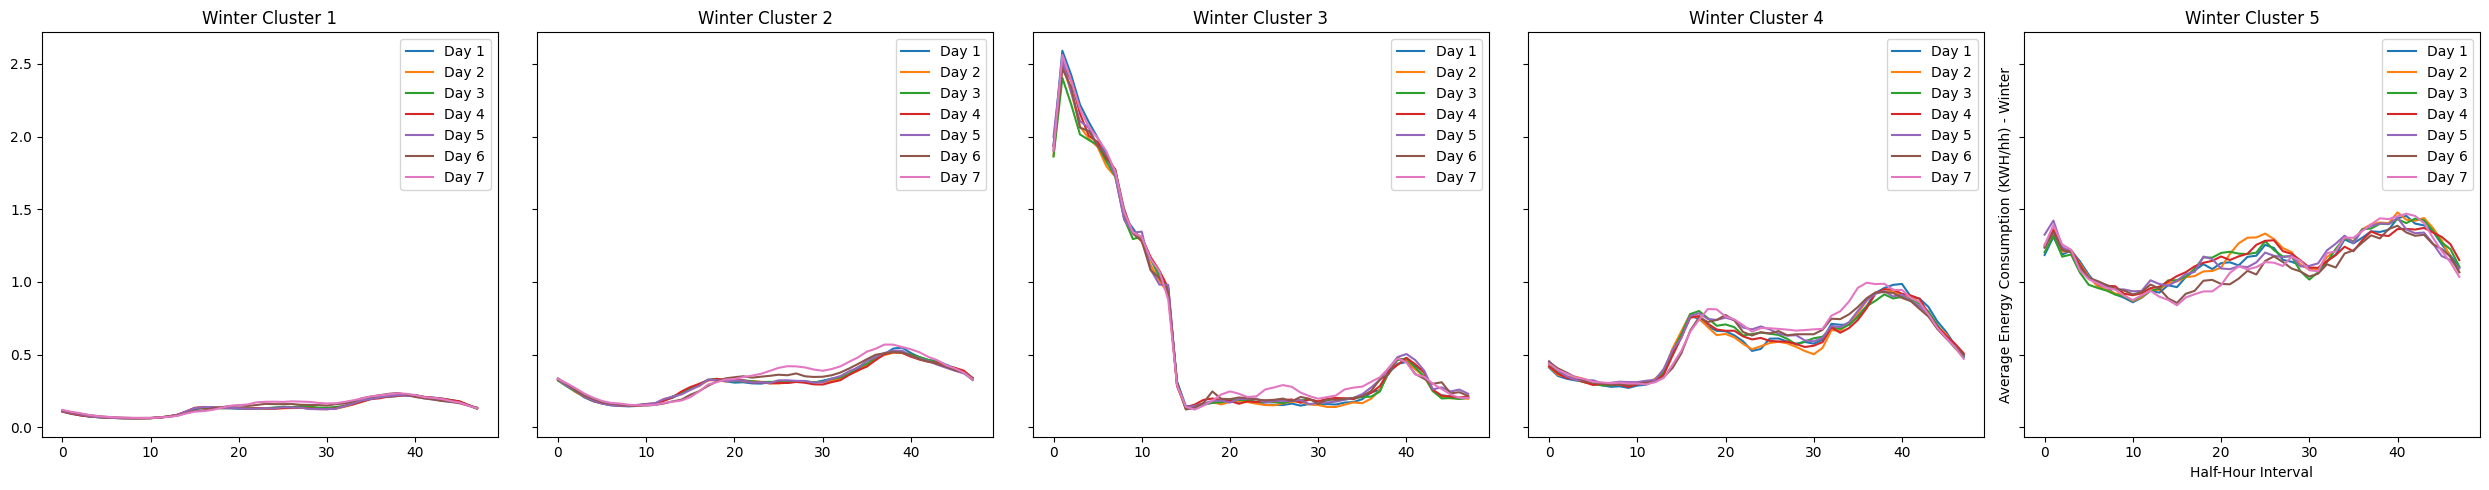

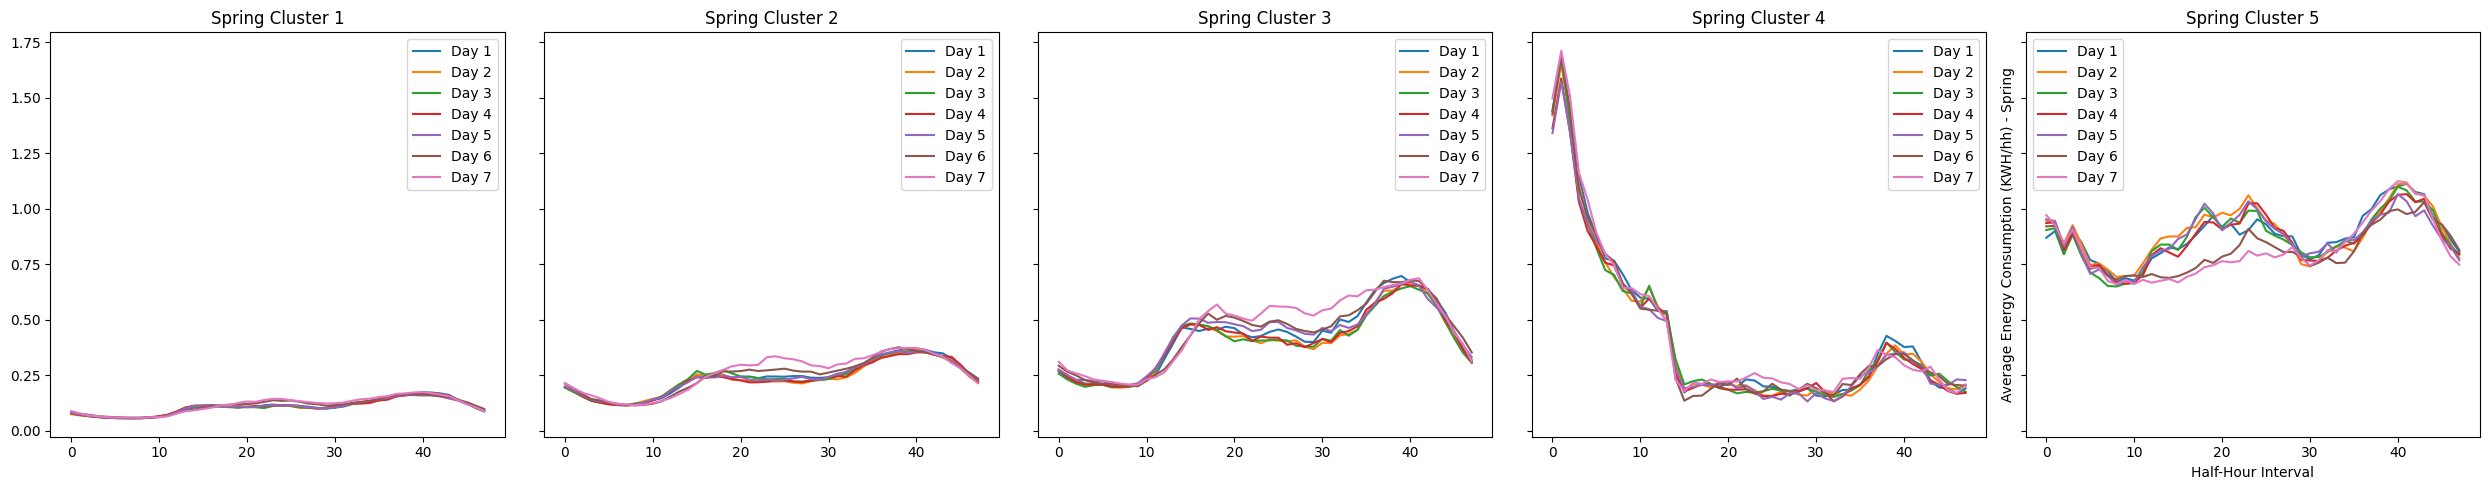

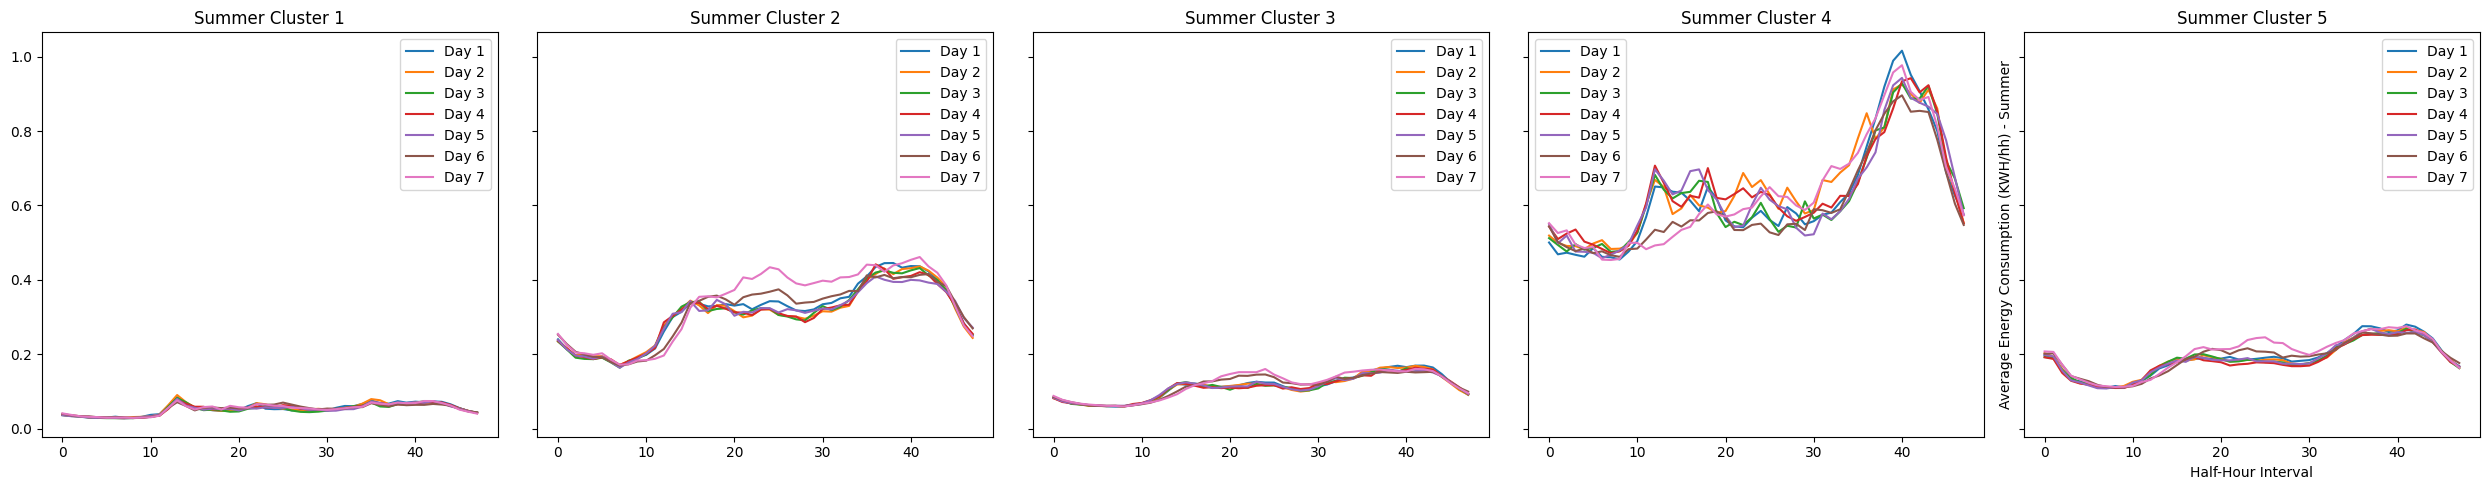

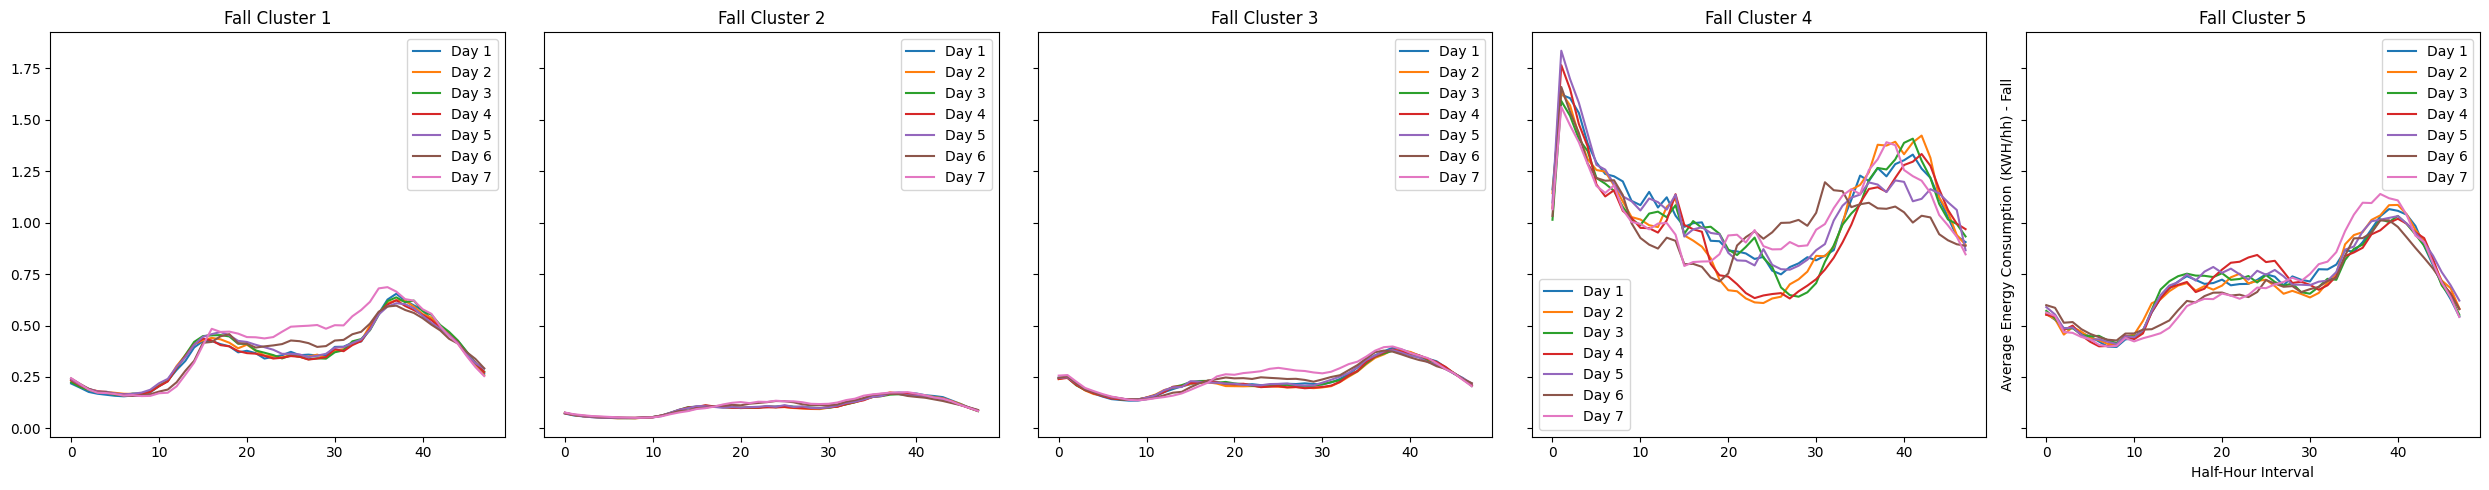

In [17]:
# Define seasons based on month
def assign_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'

combined_df['Season'] = combined_df['DateTime'].dt.month.apply(assign_season)

# Extract day of week and half-hour
combined_df['DayOfWeek'] = combined_df['DateTime'].dt.dayofweek
combined_df['HalfHour'] = combined_df['DateTime'].dt.hour * 2 + combined_df['DateTime'].dt.minute // 30

# Clustering by Season
seasons = ['Winter', 'Spring', 'Summer', 'Fall']
seasonal_clusters = {}

for season in seasons:
    # Filter data for the current season
    season_data = combined_df[combined_df['Season'] == season]

    # Group data by 'LCLid', 'DayOfWeek' and 'HalfHour'
    grouped_data = season_data.groupby(['LCLid', 'DayOfWeek', 'HalfHour'])
    
    # Aggregate 'KWH/hh (per half hour)' into average per each half-hour slot
    average_profiles = grouped_data['KWH/hh (per half hour) '].mean().unstack([1, 2])
    average_profiles = average_profiles.fillna(0)  # Fill missing values

    # Clustering
    data_for_clustering = average_profiles.values
    kmeans = KMeans(n_clusters=5, random_state=42)
    clusters = kmeans.fit_predict(data_for_clustering)

    # Store clusters for the season
    seasonal_clusters[season] = (kmeans, clusters)

    # Plot the results
    fig, axes = plt.subplots(1, 5, figsize=(25, 5), sharey=True)
    for i in range(5):
        cluster_center = kmeans.cluster_centers_[i].reshape(7, 48)
        for day in range(7):
            axes[i].plot(cluster_center[day], label=f'Day {day + 1}')
        axes[i].set_title(f'{season} Cluster {i + 1}')
        axes[i].legend()

    plt.xlabel('Half-Hour Interval')
    plt.ylabel(f'Average Energy Consumption (KWH/hh) - {season}')
    plt.tight_layout()
    plt.show()


Preparing season data

In [18]:
# Define season ranges based on day of year
season_ranges = {
    'Winter': ((1, 59), (335, 365)),  # Jan 1 to Feb 28 and Dec 1 to Dec 31
    'Spring': (60, 151),  # Mar 1 to May 31
    'Summer': (152, 243),  # Jun 1 to Aug 31
    'Fall': (244, 334)  # Sep 1 to Nov 30
}

# Create a dictionary to store seasonal CO2 data arrays
seasonal_co2_data = {}

# Filter and store data for each season
for season, ranges in season_ranges.items():
    if season == 'Winter':
        winter_mask1 = (co2_data['Timestamp'].dt.dayofyear >= ranges[0][0]) & (co2_data['Timestamp'].dt.dayofyear <= ranges[0][1])
        winter_mask2 = (co2_data['Timestamp'].dt.dayofyear >= ranges[1][0]) & (co2_data['Timestamp'].dt.dayofyear <= ranges[1][1])
        seasonal_co2_data[season] = np.concatenate((co2_data[winter_mask1]['Value'].to_numpy(), co2_data[winter_mask2]['Value'].to_numpy()))
    else:
        start_day, end_day = ranges
        season_mask = (co2_data['Timestamp'].dt.dayofyear >= start_day) & (co2_data['Timestamp'].dt.dayofyear <= end_day)
        seasonal_co2_data[season] = co2_data[season_mask]['Value'].to_numpy()

# Print the length of each season's data to verify
for season, data in seasonal_co2_data.items():
    print(f"{season} data length: {len(data)}")


Winter data length: 4320
Spring data length: 4416
Summer data length: 4416
Fall data length: 4286


Clustering for season - six most intensive energy slots

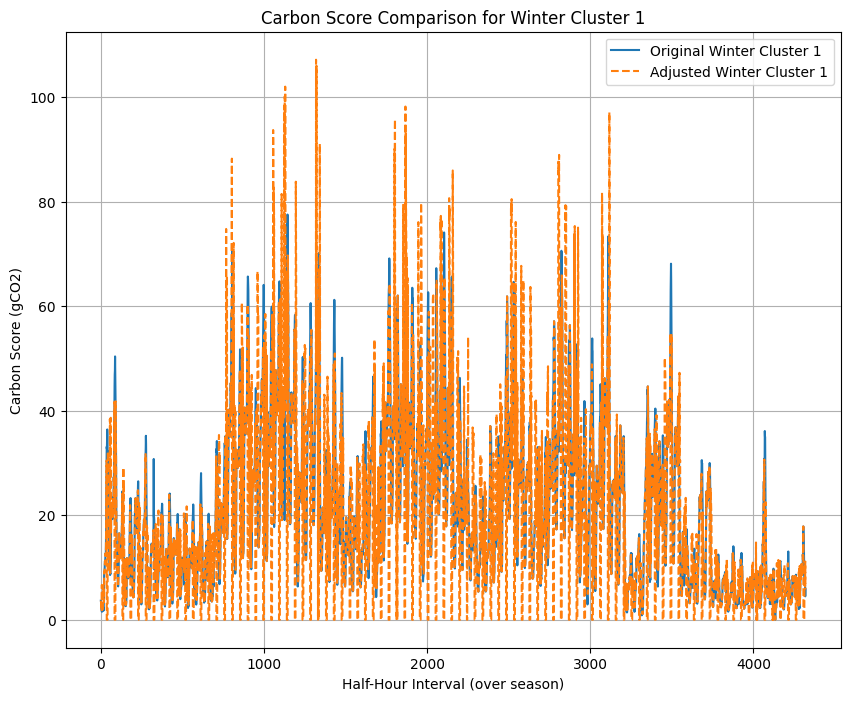

Original Total kgCO2 for Winter Cluster 1: 92.85 kg
Adjusted Total kgCO2 for Winter Cluster 1: 85.73 kg


/var/folders/6g/f3y_cgbn1jg0cwr_s63ptgy40000gn/T/ipykernel_97396/3886847885.py:68: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)


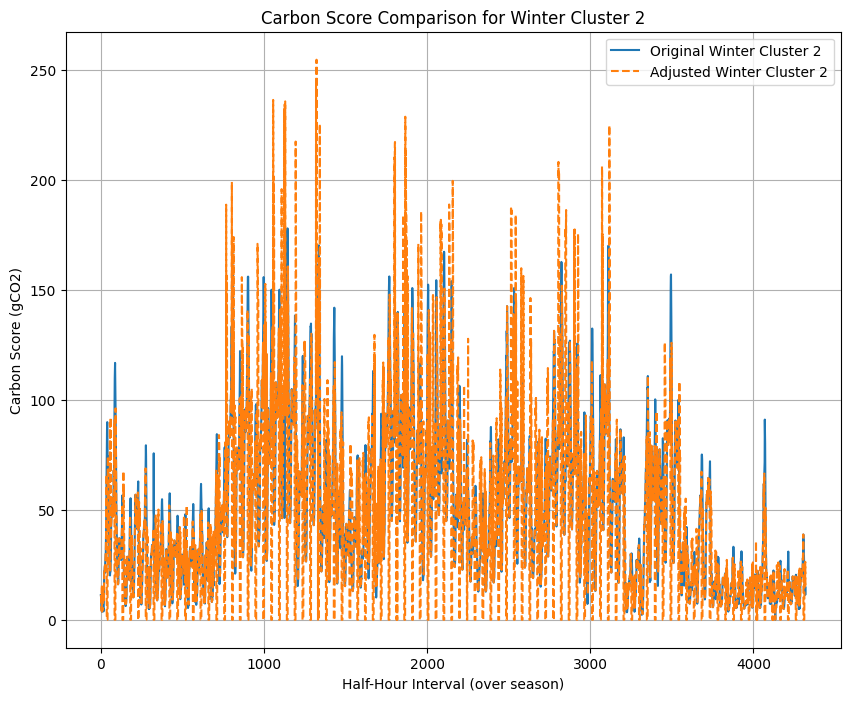

Original Total kgCO2 for Winter Cluster 2: 219.46 kg
Adjusted Total kgCO2 for Winter Cluster 2: 202.57 kg


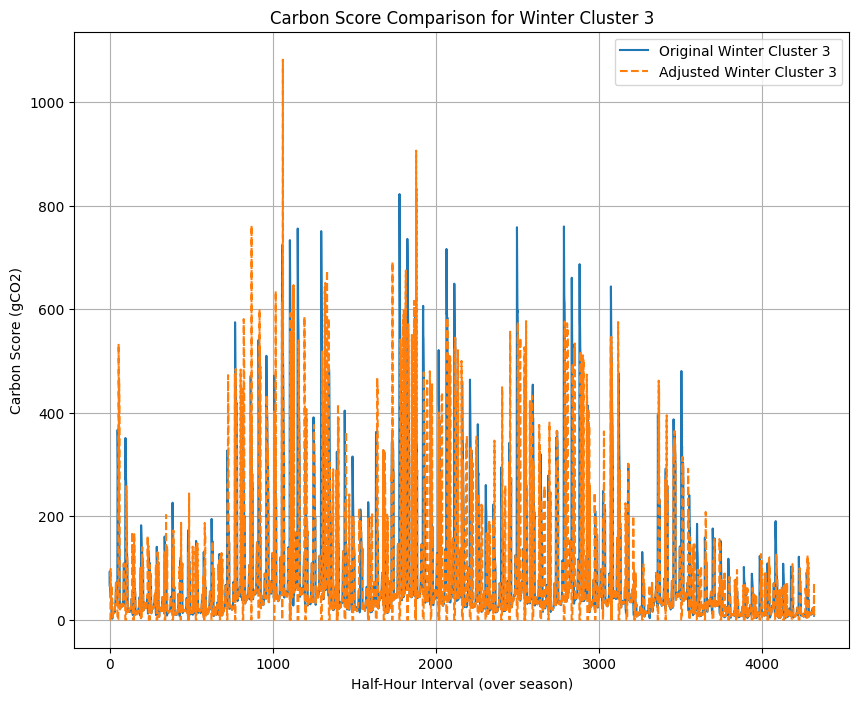

Original Total kgCO2 for Winter Cluster 3: 407.17 kg
Adjusted Total kgCO2 for Winter Cluster 3: 377.55 kg


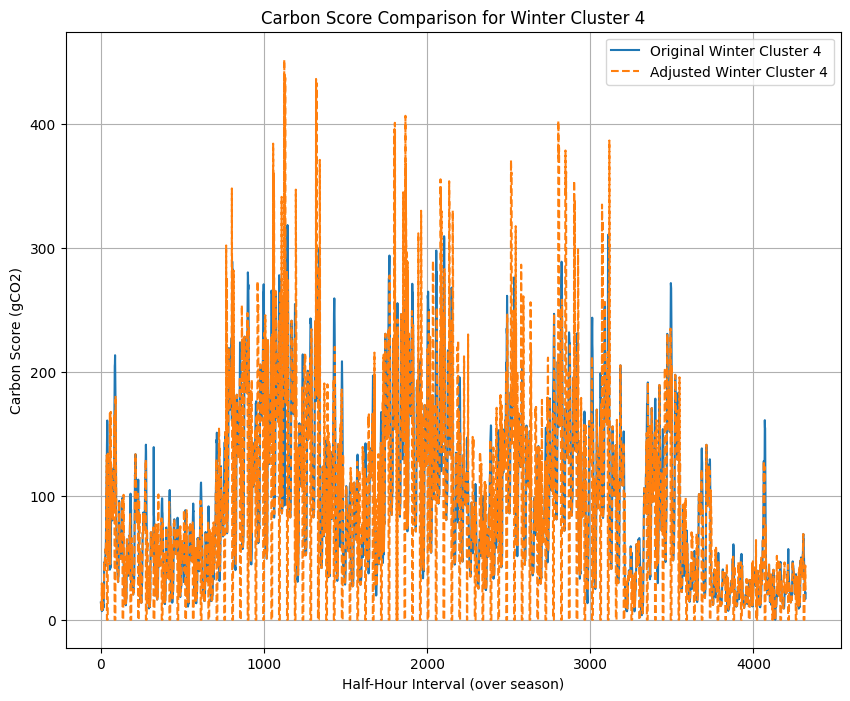

Original Total kgCO2 for Winter Cluster 4: 407.55 kg
Adjusted Total kgCO2 for Winter Cluster 4: 377.65 kg


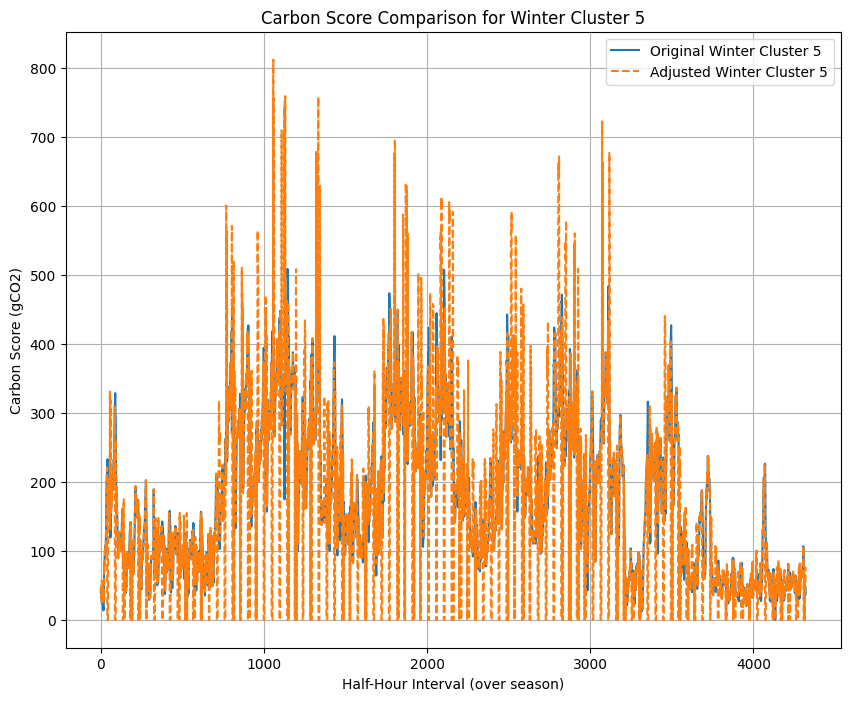

Original Total kgCO2 for Winter Cluster 5: 775.39 kg
Adjusted Total kgCO2 for Winter Cluster 5: 732.84 kg


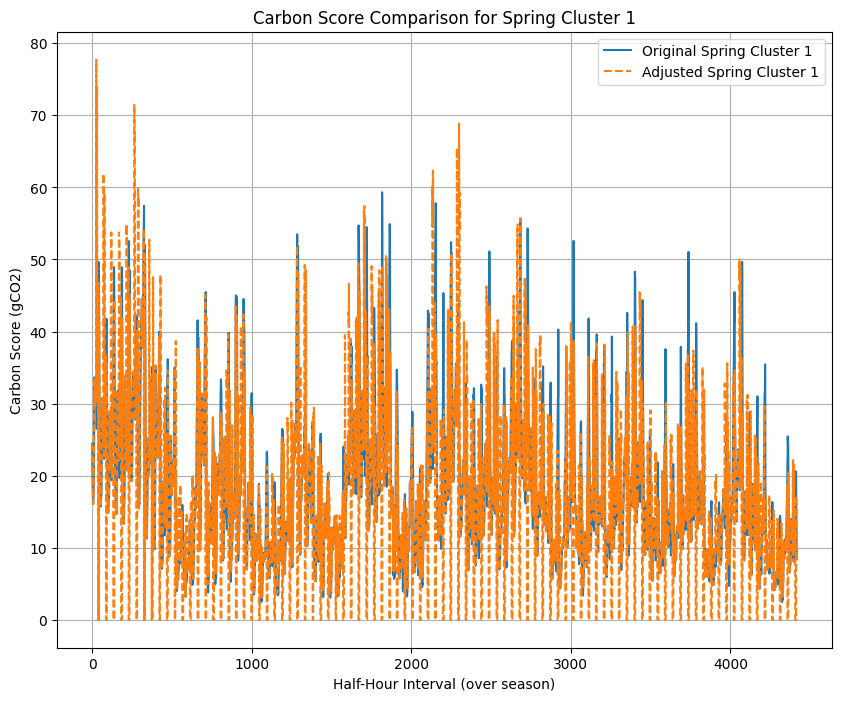

Original Total kgCO2 for Spring Cluster 1: 81.21 kg
Adjusted Total kgCO2 for Spring Cluster 1: 73.95 kg


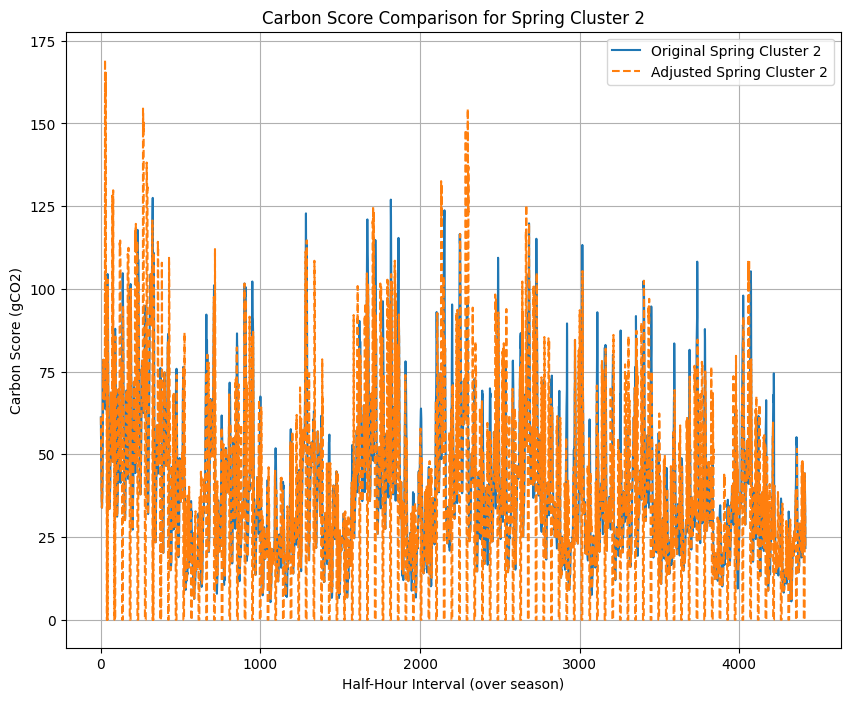

Original Total kgCO2 for Spring Cluster 2: 179.49 kg
Adjusted Total kgCO2 for Spring Cluster 2: 163.43 kg


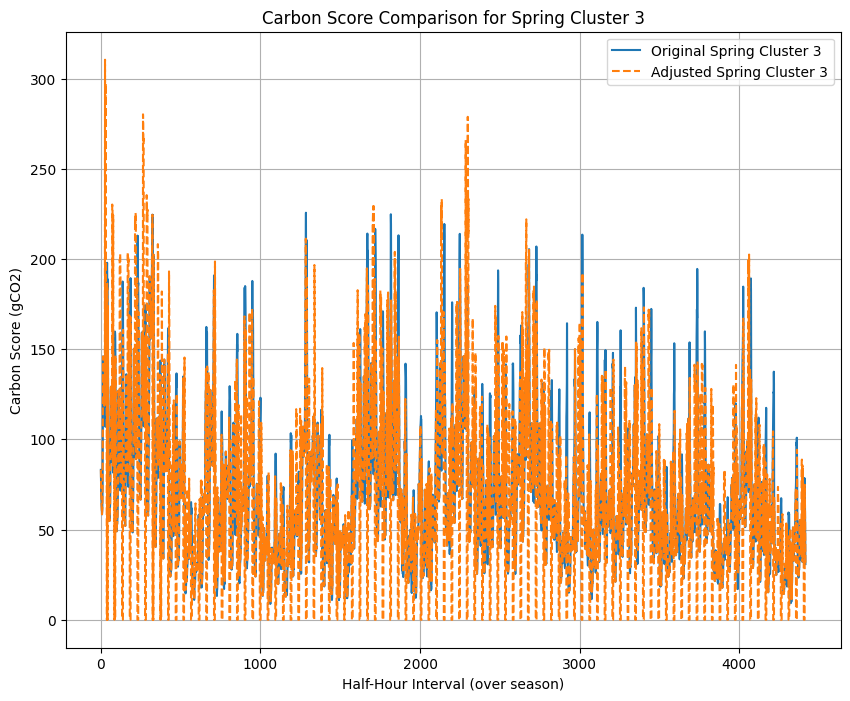

Original Total kgCO2 for Spring Cluster 3: 315.02 kg
Adjusted Total kgCO2 for Spring Cluster 3: 285.77 kg


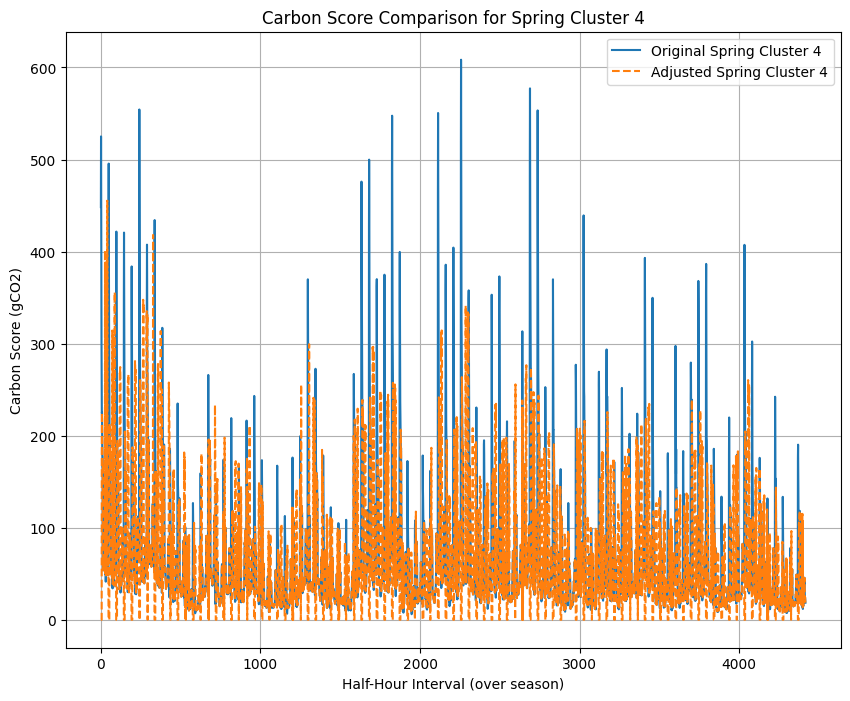

Original Total kgCO2 for Spring Cluster 4: 314.83 kg
Adjusted Total kgCO2 for Spring Cluster 4: 280.40 kg


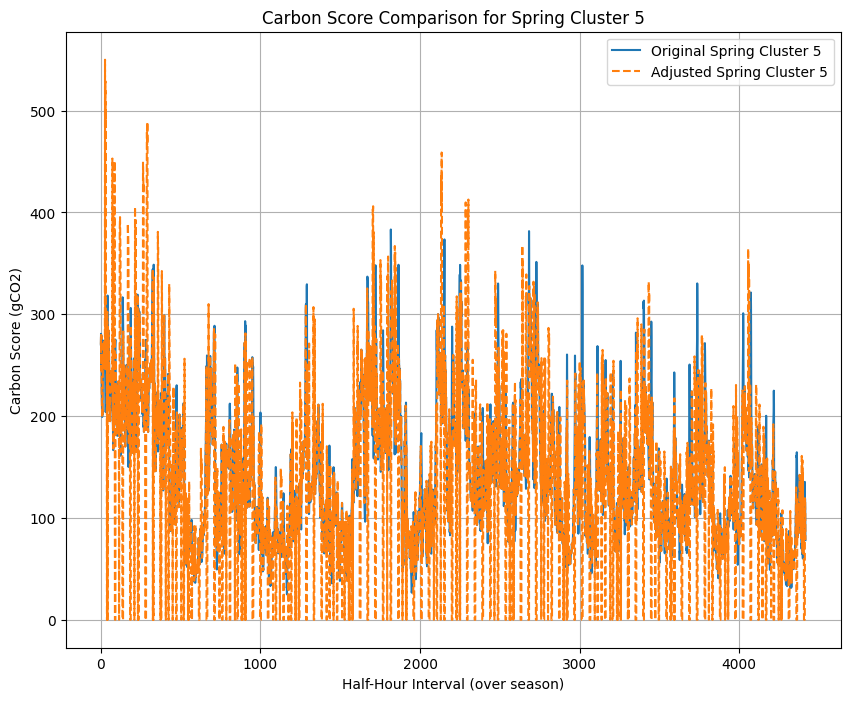

Original Total kgCO2 for Spring Cluster 5: 635.73 kg
Adjusted Total kgCO2 for Spring Cluster 5: 595.00 kg


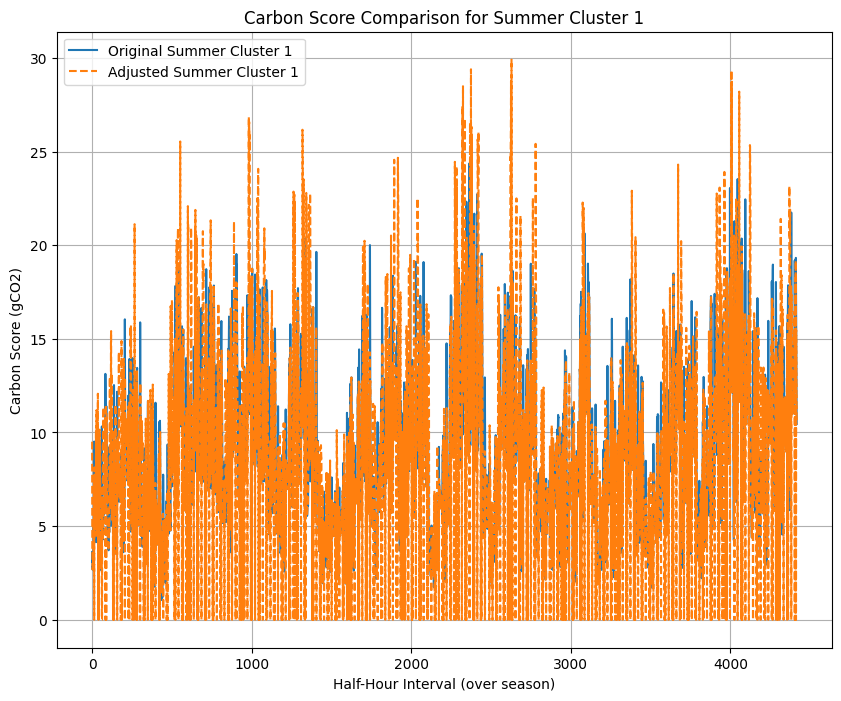

Original Total kgCO2 for Summer Cluster 1: 39.08 kg
Adjusted Total kgCO2 for Summer Cluster 1: 36.68 kg


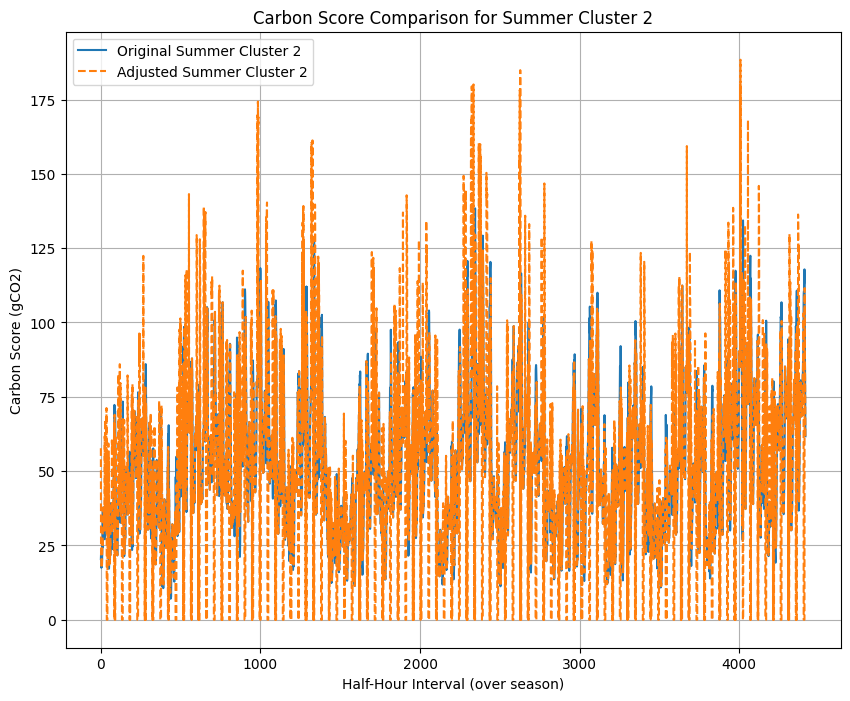

Original Total kgCO2 for Summer Cluster 2: 232.57 kg
Adjusted Total kgCO2 for Summer Cluster 2: 217.19 kg


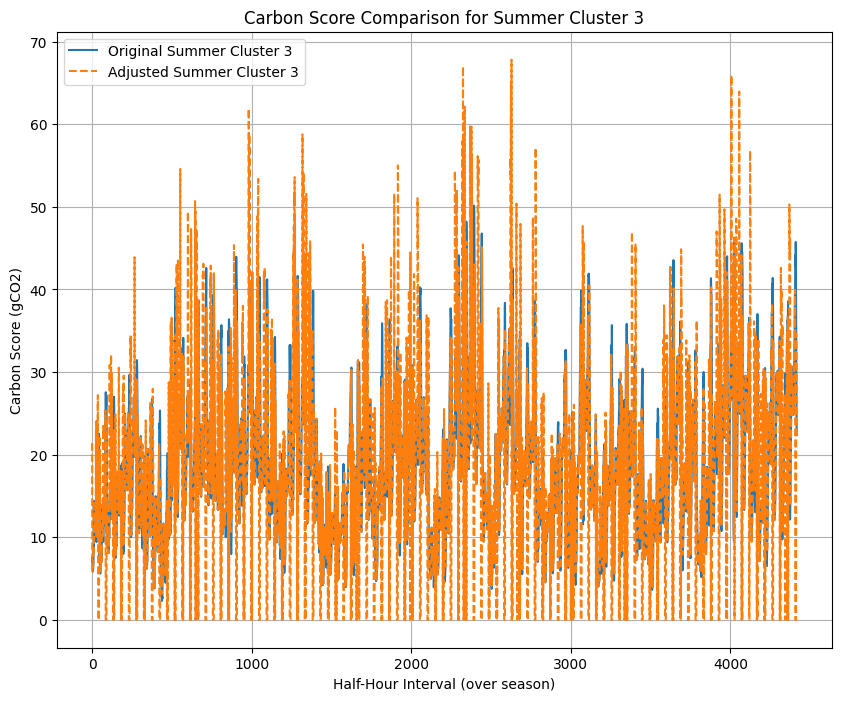

Original Total kgCO2 for Summer Cluster 3: 84.15 kg
Adjusted Total kgCO2 for Summer Cluster 3: 78.47 kg


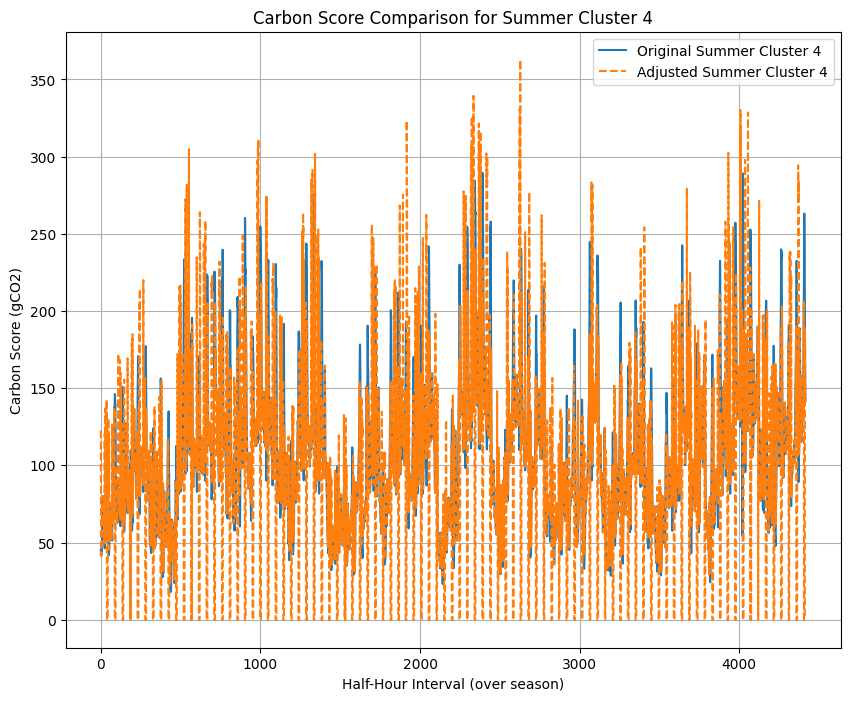

Original Total kgCO2 for Summer Cluster 4: 468.59 kg
Adjusted Total kgCO2 for Summer Cluster 4: 436.12 kg


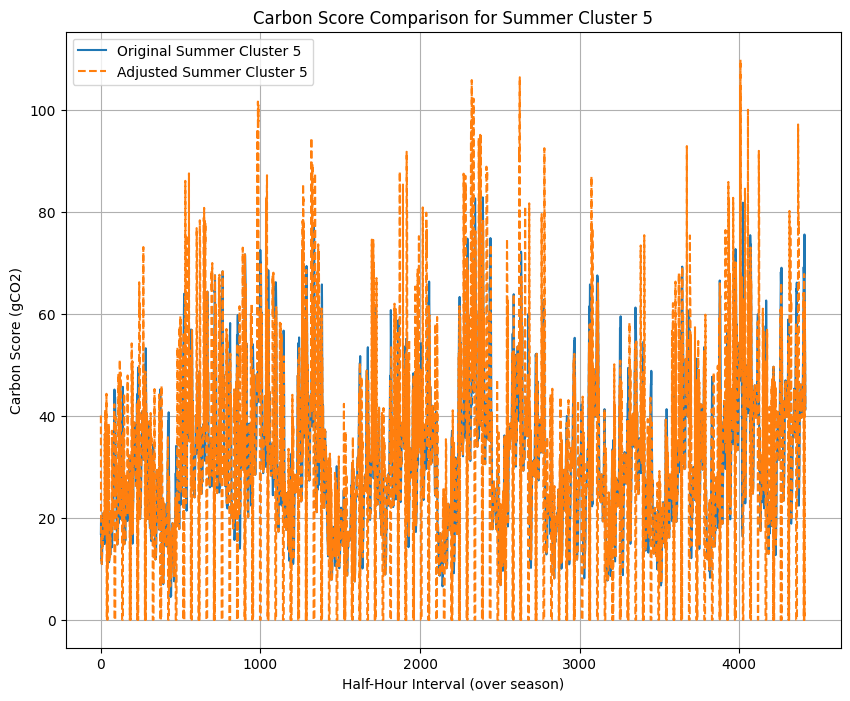

Original Total kgCO2 for Summer Cluster 5: 141.93 kg
Adjusted Total kgCO2 for Summer Cluster 5: 132.27 kg


ValueError: cannot reshape array of size 4286 into shape (48)

In [19]:
# Prepare a DataFrame to store results
results = pd.DataFrame(columns=['Season', 'Cluster', 'Original kgCO2', 'Adjusted kgCO2', 'Reduction %'])

# Iterate over each season to calculate carbon scores
for season in ['Winter', 'Spring', 'Summer', 'Fall']:
    kmeans, clusters = seasonal_clusters[season]
    co2_data_for_season = seasonal_co2_data[season]
    # Retrieve the average profiles used for clustering
    season_data = combined_df[combined_df['Season'] == season]
    grouped_data = season_data.groupby(['LCLid', 'DayOfWeek', 'HalfHour'])
    average_profiles = grouped_data['KWH/hh (per half hour) '].mean().unstack([1, 2])
    average_profiles.fillna(0, inplace=True)
    data_for_clustering = average_profiles.values

    for i in range(5):  # 5 clusters per season
        cluster_indices = np.where(clusters == i)[0]  # Indices of rows in this cluster
        cluster_data = data_for_clustering[cluster_indices]
        daily_mean_profile = cluster_data.mean(axis=0)

        # Calculate the original carbon score for the seasonal profile
        seasonal_energy_profile = np.tile(daily_mean_profile, (len(co2_data_for_season) // 48) + 1)[:len(co2_data_for_season)]
        daily_profiles = seasonal_energy_profile.reshape(-1, 48)
        original_daily_profiles = np.copy(daily_profiles)
        original_seasonal_profile = original_daily_profiles.flatten()
        original_seasonal_carbon_score = original_seasonal_profile * co2_data_for_season

        # Apply energy redistribution for adjusted profiles
        adjusted_daily_profiles = np.copy(daily_profiles)
        for day in range(daily_profiles.shape[0]):
            daily_energy = daily_profiles[day]
            daily_co2_intensity = co2_data_for_season[day * 48:(day + 1) * 48]
            lowest_indices = np.argsort(daily_co2_intensity)[:6]
            most_intensive_energy_indices = np.argsort(daily_energy)[-6:]
            total_energy_to_shift = np.sum(daily_energy[most_intensive_energy_indices])
            adjusted_daily_profiles[day, most_intensive_energy_indices] = 0
            added_energy_per_slot = total_energy_to_shift / 6
            adjusted_daily_profiles[day, lowest_indices] += added_energy_per_slot

        adjusted_seasonal_profile = adjusted_daily_profiles.flatten()
        adjusted_seasonal_carbon_score = adjusted_seasonal_profile * co2_data_for_season

        # Plot original and adjusted carbon scores
        plt.figure(figsize=(10, 8))
        plt.plot(original_seasonal_carbon_score, label=f'Original {season} Cluster {i+1}')
        plt.plot(adjusted_seasonal_carbon_score, label=f'Adjusted {season} Cluster {i+1}', linestyle='--')
        plt.title(f'Carbon Score Comparison for {season} Cluster {i+1}')
        plt.xlabel('Half-Hour Interval (over season)')
        plt.ylabel('Carbon Score (gCO2)')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Calculate total emissions in kg and percentage reduction
        original_total_kgCO2 = np.sum(original_seasonal_carbon_score) / 1000
        adjusted_total_kgCO2 = np.sum(adjusted_seasonal_carbon_score) / 1000
        reduction_percent = ((original_total_kgCO2 - adjusted_total_kgCO2) / original_total_kgCO2) * 100

        # Prepare a new row for DataFrame
        new_row = pd.DataFrame({
            'Season': [season],
            'Cluster': [i + 1],
            'Original kgCO2': [original_total_kgCO2],
            'Adjusted kgCO2': [adjusted_total_kgCO2],
            'Reduction %': [reduction_percent]
        })

        # Append the new row to the results DataFrame using concat
        results = pd.concat([results, new_row], ignore_index=True)

        print(f"Original Total kgCO2 for {season} Cluster {i+1}: {original_total_kgCO2:.2f} kg")
        print(f"Adjusted Total kgCO2 for {season} Cluster {i+1}: {adjusted_total_kgCO2:.2f} kg")

# Display the results in a table
print(results)


In [ ]:
# Prepare a DataFrame to store results
results = pd.DataFrame(columns=['Season', 'Cluster', 'Original kgCO2', 'Adjusted kgCO2', 'Reduction %'])

# Iterate over each season to calculate carbon scores
for season in ['Winter', 'Spring', 'Summer', 'Fall']:
    kmeans, clusters = seasonal_clusters[season]
    co2_data_for_season = seasonal_co2_data[season]
    
    # Retrieve the average profiles used for clustering from your previous setup
    season_data = combined_df[combined_df['Season'] == season]
    grouped_data = season_data.groupby(['LCLid', 'DayOfWeek', 'HalfHour'])
    average_profiles = grouped_data['KWH/hh (per half hour) '].mean().unstack([1, 2])
    average_profiles.fillna(0, inplace=True)
    data_for_clustering = average_profiles.values

    for i in range(5):  # 5 clusters per season
        cluster_data = data_for_clustering[clusters == i]
        daily_mean_profile = cluster_data.mean(axis=0)

        # Calculate the original carbon score for the seasonal profile
        num_complete_days = len(co2_data_for_season) // 48
        seasonal_energy_profile = np.tile(daily_mean_profile, num_complete_days + 1)[:num_complete_days * 48]
        daily_profiles = seasonal_energy_profile.reshape(-1, 48)
        original_daily_profiles = np.copy(daily_profiles)
        original_seasonal_profile = original_daily_profiles.flatten()
        original_seasonal_carbon_score = original_seasonal_profile * co2_data_for_season[:len(original_seasonal_profile)]

        # Apply energy redistribution for adjusted profiles
        adjusted_daily_profiles = np.copy(daily_profiles)
        for day in range(daily_profiles.shape[0]):
            daily_energy = daily_profiles[day]
            daily_co2_intensity = co2_data_for_season[day * 48:(day + 1) * 48]
            lowest_indices = np.argsort(daily_co2_intensity)[:6]
            most_intensive_energy_indices = np.argsort(daily_energy)[-6:]
            total_energy_to_shift = np.sum(daily_energy[most_intensive_energy_indices])
            adjusted_daily_profiles[day, most_intensive_energy_indices] = 0
            added_energy_per_slot = total_energy_to_shift / 6
            adjusted_daily_profiles[day, lowest_indices] += added_energy_per_slot

        adjusted_seasonal_profile = adjusted_daily_profiles.flatten()
        adjusted_seasonal_carbon_score = adjusted_seasonal_profile * co2_data_for_season[:len(adjusted_seasonal_profile)]

        # Calculate total emissions in kg and percentage reduction
        original_total_kgCO2 = np.sum(original_seasonal_carbon_score) / 1000
        adjusted_total_kgCO2 = np.sum(adjusted_seasonal_carbon_score) / 1000
        reduction_percent = ((original_total_kgCO2 - adjusted_total_kgCO2) / original_total_kgCO2) * 100

        # Store results in the DataFrame
        results = pd.concat([results, pd.DataFrame({
            'Season': [season],
            'Cluster': [i + 1],
            'Original kgCO2': [original_total_kgCO2],
            'Adjusted kgCO2': [adjusted_total_kgCO2],
            'Reduction %': [reduction_percent]
        })], ignore_index=True)

        #print(f"Original Total kgCO2 for {season} Cluster {i+1}: {original_total_kgCO2:.2f} kg")
        #print(f"Adjusted Total kgCO2 for {season} Cluster {i+1}: {adjusted_total_kgCO2:.2f} kg")

# Display the results in a table
print(results)


Flexing - most intensive energy periods

In [ ]:
# Prepare a DataFrame to store results
results = pd.DataFrame(columns=['Season', 'Cluster', 'Original kgCO2', 'Adjusted kgCO2', 'Reduction %'])

# Assuming 'seasonal_clusters' and 'seasonal_co2_data' are already defined from previous steps
for season in ['Winter', 'Spring', 'Summer', 'Fall']:
    # Retrieve the average profiles used for clustering from your previous setup
    season_data = combined_df[combined_df['Season'] == season]
    grouped_data = season_data.groupby(['LCLid', 'DayOfWeek', 'HalfHour'])
    average_profiles = grouped_data['KWH/hh (per half hour) '].mean().unstack([1, 2])
    average_profiles.fillna(0, inplace=True)
    data_for_clustering = average_profiles.values

    # Perform clustering
    kmeans = KMeans(n_clusters=5, random_state=42)
    clusters = kmeans.fit_predict(data_for_clustering)

    co2_data_for_season = seasonal_co2_data[season]

    for i in range(5):  # 5 clusters per season
        cluster_data = data_for_clustering[clusters == i]
        daily_mean_profile = cluster_data.mean(axis=0)

        # Calculate the original and adjusted carbon scores
        num_complete_days = len(co2_data_for_season) // 48
        seasonal_energy_profile = np.tile(daily_mean_profile, num_complete_days + 1)[:num_complete_days * 48]
        daily_profiles = seasonal_energy_profile.reshape(-1, 48)
        original_daily_profiles = np.copy(daily_profiles)
        original_seasonal_profile = original_daily_profiles.flatten()
        original_seasonal_carbon_score = original_seasonal_profile * co2_data_for_season[:len(original_seasonal_profile)]

        # Apply energy redistribution
        adjusted_daily_profiles = np.copy(daily_profiles)
        for day in range(daily_profiles.shape[0]):
            daily_energy = daily_profiles[day]
            daily_co2_intensity = co2_data_for_season[day * 48:(day + 1) * 48]
            lowest_indices = np.argsort(daily_co2_intensity)[:6]
            most_intensive_energy_indices = np.argsort(daily_co2_intensity)[-6:]
            total_energy_to_shift = np.sum(daily_energy[most_intensive_energy_indices])
            adjusted_daily_profiles[day, most_intensive_energy_indices] = 0
            added_energy_per_slot = total_energy_to_shift / 6
            adjusted_daily_profiles[day, lowest_indices] += added_energy_per_slot

        adjusted_seasonal_profile = adjusted_daily_profiles.flatten()
        adjusted_seasonal_carbon_score = adjusted_seasonal_profile * co2_data_for_season[:len(adjusted_seasonal_profile)]

        # Plot original and adjusted carbon scores
        plt.figure(figsize=(10, 8))
        plt.plot(original_seasonal_carbon_score, label=f'Original {season} Cluster {i+1}')
        plt.plot(adjusted_seasonal_carbon_score, label=f'Adjusted {season} Cluster {i+1}', linestyle='--')
        plt.title(f'Carbon Score Comparison for {season} Cluster {i+1}')
        plt.xlabel('Half-Hour Interval (over season)')
        plt.ylabel('Carbon Score (gCO2)')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Store and print results
        original_total_kgCO2 = np.sum(original_seasonal_carbon_score) / 1000
        adjusted_total_kgCO2 = np.sum(adjusted_seasonal_carbon_score) / 1000
        reduction_percent = ((original_total_kgCO2 - adjusted_total_kgCO2) / original_total_kgCO2) * 100
        results = pd.concat([results, pd.DataFrame({
            'Season': [season],
            'Cluster': [i + 1],
            'Original kgCO2': [original_total_kgCO2],
            'Adjusted kgCO2': [adjusted_total_kgCO2],
            'Reduction %': [reduction_percent]
        })], ignore_index=True)

        print(f"Original Total kgCO2 for {season} Cluster {i+1}: {original_total_kgCO2:.2f} kg")
        print(f"Adjusted Total kgCO2 for {season} Cluster {i+1}: {adjusted_total_kgCO2:.2f} kg")

# Display the results in a table
print(results)


Flexing for season - 30% of energy redistributed

In [ ]:
# Prepare a DataFrame to store results
results = pd.DataFrame(columns=['Season', 'Cluster', 'Original kgCO2', 'Adjusted kgCO2', 'Reduction %'])

for season in ['Winter', 'Spring', 'Summer', 'Fall']:
    # Retrieve the average profiles used for clustering from your previous setup
    season_data = combined_df[combined_df['Season'] == season]
    grouped_data = season_data.groupby(['LCLid', 'DayOfWeek', 'HalfHour'])
    average_profiles = grouped_data['KWH/hh (per half hour) '].mean().unstack([1, 2])
    average_profiles.fillna(0, inplace=True)
    data_for_clustering = average_profiles.values

    # Perform clustering
    kmeans = KMeans(n_clusters=5, random_state=42)
    clusters = kmeans.fit_predict(data_for_clustering)

    co2_data_for_season = seasonal_co2_data[season]

    for i in range(5):  # 5 clusters per season
        cluster_data = data_for_clustering[clusters == i]
        daily_mean_profile = cluster_data.mean(axis=0)

        # Calculate the original carbon score for the seasonal profile
        num_complete_days = len(co2_data_for_season) // 48
        seasonal_energy_profile = np.tile(daily_mean_profile, num_complete_days + 1)[:num_complete_days * 48]
        daily_profiles = seasonal_energy_profile.reshape(-1, 48)
        original_daily_profiles = np.copy(daily_profiles)
        original_seasonal_profile = original_daily_profiles.flatten()
        original_seasonal_carbon_score = original_seasonal_profile * co2_data_for_season[:len(original_seasonal_profile)]

       # Apply energy redistribution for adjusted profiles
        adjusted_daily_profiles = np.copy(daily_profiles)
        for day in range(daily_profiles.shape[0]):
            daily_energy = daily_profiles[day]
            energy_to_redistribute = np.sum(daily_energy) * 0.30
            daily_co2_intensity = co2_data_for_season[day * 48:(day + 1) * 48]
            lowest_indices = np.argsort(daily_co2_intensity)[:6]

            # Proportionally reduce the daily energy to remove the 30%
            energy_reduction = daily_energy * 0.30
            daily_energy -= energy_reduction

            # Redistribute the removed energy to the lowest slots
            added_energy_per_slot = energy_to_redistribute / 6
            daily_energy[lowest_indices] += added_energy_per_slot
            adjusted_daily_profiles[day] = daily_energy

        adjusted_seasonal_profile = adjusted_daily_profiles.flatten()
        adjusted_seasonal_carbon_score = adjusted_seasonal_profile * co2_data_for_season[:len(adjusted_seasonal_profile)]

        # Plot original and adjusted carbon scores
        plt.figure(figsize=(10, 8))
        plt.plot(original_seasonal_carbon_score, label=f'Original {season} Cluster {i+1}')
        plt.plot(adjusted_seasonal_carbon_score, label=f'Adjusted {season} Cluster {i+1}', linestyle='--')
        plt.title(f'Carbon Score Comparison for {season} Cluster {i+1}')
        plt.xlabel('Half-Hour Interval (over season)')
        plt.ylabel('Carbon Score (gCO2)')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Calculate total emissions in kg and percentage reduction
        original_total_kgCO2 = np.sum(original_seasonal_carbon_score) / 1000
        adjusted_total_kgCO2 = np.sum(adjusted_seasonal_carbon_score) / 1000
        reduction_percent = ((original_total_kgCO2 - adjusted_total_kgCO2) / original_total_kgCO2) * 100

        # Store results in the DataFrame
        results = pd.concat([results, pd.DataFrame({
            'Season': [season],
            'Cluster': [i + 1],
            'Original kgCO2': [original_total_kgCO2],
            'Adjusted kgCO2': [adjusted_total_kgCO2],
            'Reduction %': [reduction_percent]
        })], ignore_index=True)

        print(f"Original Total kgCO2 for {season} Cluster {i+1}: {original_total_kgCO2:.2f} kg")
        print(f"Adjusted Total kgCO2 for {season} Cluster {i+1}: {adjusted_total_kgCO2:.2f} kg")

# Display the results in a table
print(results)